In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import math
import random

from scipy import stats
from scipy import optimize

import pandas as pd
from scipy.optimize import curve_fit

import seaborn as sns
try:
    sns.set_style("ticks") 
    #sns.set_style({"axes.axisbelow": False})
    sns.set_style({"xtick.direction": "in" ,"ytick.direction": "in"})
except:
    print("sns problem")

from pbh import *

import emcee



Can't import ROOT, no related functionality possible


In [2]:
def deg2rad(deg):
    return deg / 180. * np.pi

def rad2deg(rad):
    return rad * 180. / np.pi

def get_angular_distance(coord1, coord2):
    """
    coord1 and coord2 are in [ra, dec] format in degrees
    """
    return rad2deg(np.arccos(np.sin(deg2rad(coord1[1])) * np.sin(deg2rad(coord2[1])) \
                             + np.cos(deg2rad(coord1[1])) * np.cos(deg2rad(coord2[1])) * \
                             np.cos(deg2rad(coord1[0]) - deg2rad(coord2[0]))))

def get_all_angular_distance(coords, cent_coord):
        assert coords.shape[1] == 2
        dists = np.zeros(coords.shape[0])
        for i, coord in enumerate(coords):
            dists[i] = get_angular_distance(coord, cent_coord)
        return dists
    
def centroid_log_likelihood(cent_coord, coords, psfs):
        """
        returns ll=-2*ln(L)
        """
        ll = 0
        dists = get_all_angular_distance(coords, cent_coord)
        theta2s = dists ** 2
        #ll = -2.* np.log(  1.7142 * N / 2. / np.pi / (psf_width ** 2) / np.cosh(np.sqrt(theta2) / psf_width)  )
        ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
        ll += psfs.shape[0] * np.log(1.7142 / np.pi)
        ll = -2. * ll
        #return ll
        #Normalized by the number of events!
        return ll / psfs.shape[0]

def centroid_log_likelihood_1(cent_coord, coords, psfs):
        """
        returns ll=-2*ln(L)
        """
        ll = 0
        dists = get_all_angular_distance(coords, cent_coord)
        theta2s = dists ** 2
        #ll = -2.* np.log(  1.7142 * N / 2. / np.pi / (psf_width ** 2) / np.cosh(np.sqrt(theta2) / psf_width)  )
        ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
        ll += psfs.shape[0] * np.log(1.7142 / np.pi)
        #ll = -2. * ll
        #return ll
        #Normalized by the number of events!
        return ll / psfs.shape[0]


def minimize_centroid_ll(coords, psfs):
        init_centroid = np.mean(coords, axis=0)
        results = minimize(centroid_log_likelihood, init_centroid, args=(coords, psfs), method='L-BFGS-B')
        centroid = results.x
        ll_centroid = centroid_log_likelihood(centroid, coords, psfs)
        return centroid, ll_centroid








In [3]:
nwalkers=50
nburn=100 
nsteps=200
ndim=2

coords=np.array([[ 50.34214548,  22.76709317],
       [ 49.97230142,  22.37283718],
       [ 50.93610821,  24.03975289],
       [ 49.94503023,  23.85233075],
       [ 48.89380845,  23.25789441],
       [ 50.71810109,  22.84501269],
       [ 50.58664027,  25.21919109],
       [ 49.50921407,  23.45843913]])
psfs = np.array([0.042,0.042,0.051,0.051,0.035,0.051,0.051,0.051])

ang_dist = get_all_angular_distance(coords, np.array([ 49.97230142,  22.37283718]))
print(ang_dist)

neg2lnL = centroid_log_likelihood(np.array([ 49.97230142,  22.37283718]), coords, psfs)
print(neg2lnL)

rng = np.random.RandomState()
starting_guesses = rng.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, centroid_log_likelihood_1, args=[coords, psfs])
sampler.a = 0.1
sampler.run_mcmc(starting_guesses, nsteps)
trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
print("Mean acceptance fraction: {0:.3g}"
                .format(np.mean(sampler.acceptance_fraction)))



[ 0.52160498  0.          1.88764642  1.47970615  1.33099517  0.83483923
  2.90130965  1.16638739]
40.8630164922


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in cosh
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log
//anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
//anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Mean acceptance fraction: 0.08


In [4]:
trace.shape

(5000, 2)

In [5]:
trace

array([[ 49.78508634,  23.15066527],
       [ 49.78565988,  23.15895531],
       [ 49.78565988,  23.15895531],
       ..., 
       [ 50.00462472,  23.10279833],
       [ 50.01049286,  23.11066733],
       [ 50.01049286,  23.11066733]])

In [6]:
#trace[:,0]

In [7]:
#sns.jointplot(trace[:, 0], trace[:, 1], kind='hex')

In [8]:
#test_sim_likelihood(Nsim=1000, N_burst=3, filename=None, sig_bins=50, bkg_bins=100, ylog=True)


In [5]:
def calc_cut_sig(ll_sig_all, ll_bkg_all, ll_cut, upper=True):
    ll_sig_all=np.array(ll_sig_all)
    ll_bkg_all=np.array(ll_bkg_all)
    if upper:
        s = float((ll_sig_all<=ll_cut).sum())
        b = float((ll_bkg_all<=ll_cut).sum())
    else:
        s = float((ll_sig_all>=ll_cut).sum())
        b = float((ll_bkg_all>=ll_cut).sum())
    sig = 1.0*s/np.sqrt(s+b)
    return sig
    
def cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, upper=True, plot=True, outfile=None, 
                 label="Burst size 3", sig_bins=50, bkg_bins=100, ylog=True):
    sigs = np.zeros_like(ll_cuts).astype('float')
    for i, c in enumerate(ll_cuts):
        sig = calc_cut_sig(ll_sig_all, ll_bkg_all, c, upper=upper)
        sigs[i] = sig
    if plot:
        plt.plot(ll_cuts, sigs, color='g', label=str(label) + " SNR")
        plt.hist(ll_sig_all, bins=sig_bins, color='r', alpha=0.3, label=str(label) + " signal")
        plt.hist(ll_bkg_all, bins=bkg_bins, color='b', alpha=0.3, label=str(label) + " background")
        best_cut = ll_cuts[np.where(sigs==np.max(np.nan_to_num(sigs)))]
        plt.axvline(x=best_cut[0], ls="--", lw=0.3, label="Best cut {:.2f}".format(best_cut[0]))
        plt.axhline(y=sigs[np.where(sigs==np.max(np.nan_to_num(sigs)))][0], ls="--", lw=0.3)

        plt.legend(loc='best')
        plt.xlabel("Likelihood")
        if ylog:
            plt.yscale('log')
        if outfile is not None:
            plt.savefig(outfile)
        plt.show()
    return (sigs, best_cut[0])
    
def cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, upper=True, plot=True, outfile=None, 
                 label="Burst size 3", sig_bins=50, bkg_bins=100, ylog=True):
    #for i, c in enumerate(ll_cuts):
    #    sig = calc_cut_sig(ll_sig_all, ll_bkg_all, c, upper=upper)
    #    sigs[i] = sig
    if plot:
        #plt.plot(ll_cuts, sigs, color='g', label=str(label) + " SNR")
        plt.hist(ll_sig_all, bins=sig_bins, color='r', alpha=0.3, label=str(label) + " signal")
        plt.hist(ll_bkg_all, bins=bkg_bins, color='b', alpha=0.3, label=str(label) + " background")
        #ll_sig_all = np.nan_to_num(ll_sig_all)
        best_cut = np.percentile(ll_sig_all, 90)
        plt.axvline(x=best_cut, ls="--", lw=0.3, label="90% efficiency cut {:.2f}".format(best_cut))
        #plt.axhline(y=sigs[np.where(ll_sig_all==best_cut)][0], ls="--", lw=0.3)

        plt.legend(loc='best')
        plt.xlabel("Likelihood")
        if ylog:
            plt.yscale('log')
        if outfile is not None:
            plt.savefig(outfile)
        plt.show()
    return best_cut


In [6]:
test_pbh = Pbh()
print(test_pbh.get_psf(0.4, 15))
print(test_pbh.get_psf(0.4, 60))
print(test_pbh.get_psf(0.4, 75))
print(test_pbh.get_psf(0.4, 85))

print("====")
print(test_pbh.get_psf(1.4, 15))
print(test_pbh.get_psf(1.4, 60))
print(test_pbh.get_psf(1.4, 75))
print(test_pbh.get_psf(1.4, 85))


def get_psf(self, E=0.1, EL=80):
        E_bin = max((np.digitize(E, self.E_grid, right=True) - 1), 0)
        EL_bin = max((np.digitize(EL, self.EL_grid, right=True) - 1), 0)
        return self.psf_lookup[E_bin, EL_bin]

print("====")
print(get_psf(test_pbh, 1.4, 15))
print(test_pbh.get_psf(1.4, 60))



0.042
0.047
0.042
0.042
====
0.027
0.031
0.028
0.027
====
0.031
0.031


In [7]:
def sim_psf_likelihood(Nsim=1000, N_burst=3, filename=None, 
                       sig_bins=50, bkg_bins=100, ylog=True, 
                       EL = 75, fov_center = np.array([180., 30.0])):
    pbh = Pbh()
    
    fov = 1.75

    #spec sim:
    index = -2.5
    E_min = 0.08
    E_max = 50.0
    #Burst size to visualize
    #N_burst = 10
    #EL = 15
    pl_nu = powerlaw(index, E_min, E_max)

    #Nsim = 1000
    ll_bkg_all = np.zeros(Nsim)
    ll_sig_all = np.zeros(Nsim)

    for j in range(Nsim):
        rand_Es = pl_nu.random(N_burst)
        rand_bkg_coords = np.zeros((N_burst, 2))
        rand_sig_coords = np.zeros((N_burst, 2))
        psfs = np.zeros(N_burst)

        for i in range(N_burst):
            psf_width = pbh.get_psf(rand_Es[i], EL)
            psfs[i] = psf_width
            rand_bkg_theta = pbh.gen_one_random_theta(psf_width, prob="uniform", fov=fov)
            rand_sig_theta = pbh.gen_one_random_theta(psf_width, prob="psf", fov=fov)
            rand_bkg_coords[i, :] = pbh.gen_one_random_coords(fov_center, rand_bkg_theta)
            rand_sig_coords[i, :] = pbh.gen_one_random_coords(fov_center, rand_sig_theta)

        cent_bkg, ll_bkg = pbh.minimize_centroid_ll(rand_bkg_coords, psfs)
        cent_sig, ll_sig = pbh.minimize_centroid_ll(rand_sig_coords, psfs)
        ll_bkg_all[j] = ll_bkg
        ll_sig_all[j] = ll_sig
    return ll_sig_all, ll_bkg_all

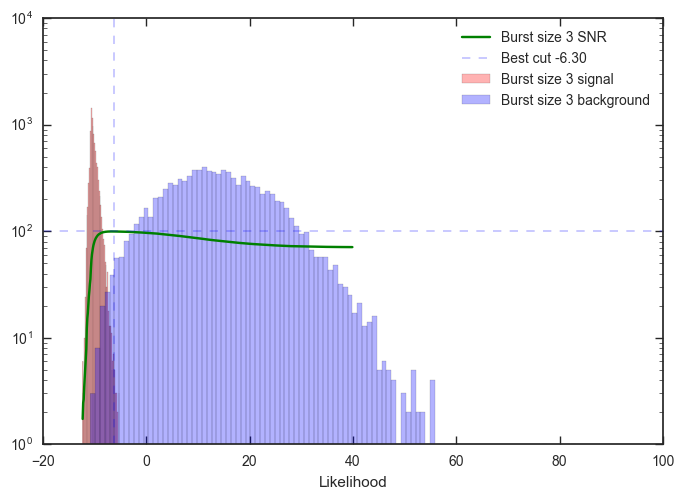

In [11]:
ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=10000, N_burst=3, filename=None, sig_bins=50, bkg_bins=100, ylog=True)
ll_cuts=np.arange(-15,40,0.1)
sigs, best_cut = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, outfile="psf_likelihood_cut_optimization_sim10000_burst_size3.png")
#sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)



In [12]:
sig_test = calc_cut_sig(ll_sig_all, ll_bkg_all, -9.5)
print(sig_test)

89.9611273924


In [18]:
def opt_cut(Nsim=10000, N_burst=3):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, sig_bins=50, bkg_bins=100, ylog=True)
    ll_cuts=np.arange(-15,40,0.1)
    sigs, best_cut = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_optimization_sim"+str(Nsim)+"_burst_size"+str(N_burst)+".png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


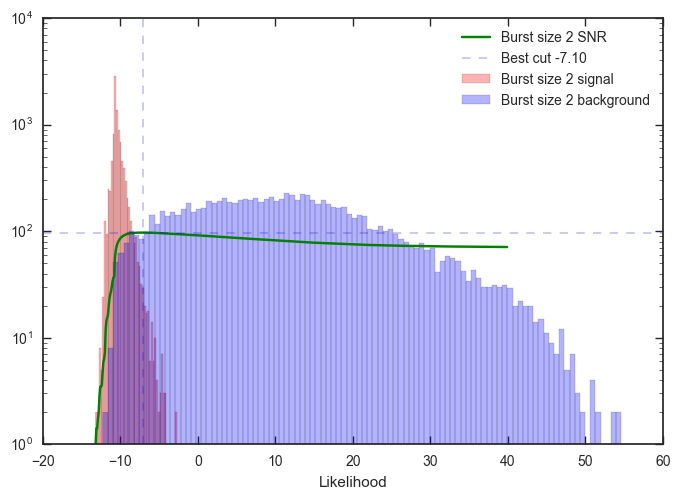

Cut for burst size 2 is -7.10


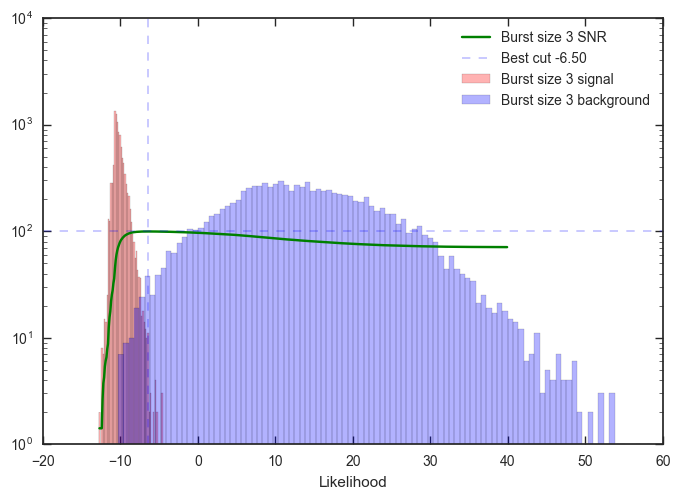

Cut for burst size 3 is -6.50


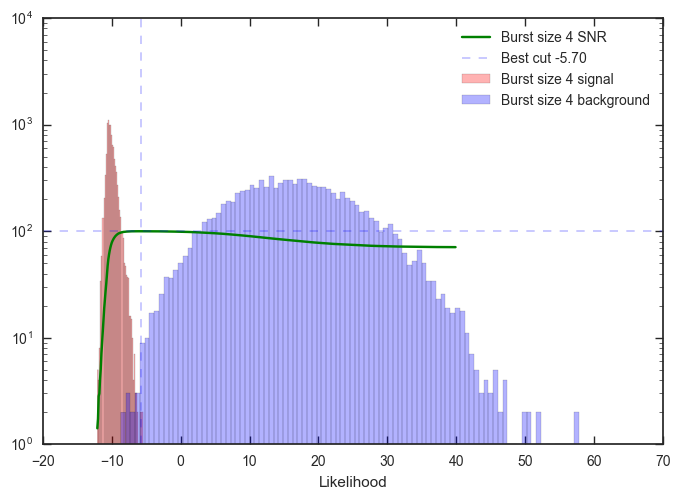

Cut for burst size 4 is -5.70


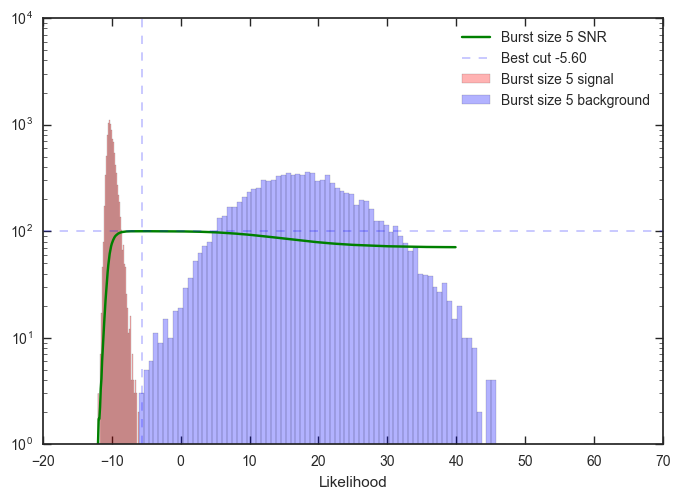

Cut for burst size 5 is -5.60


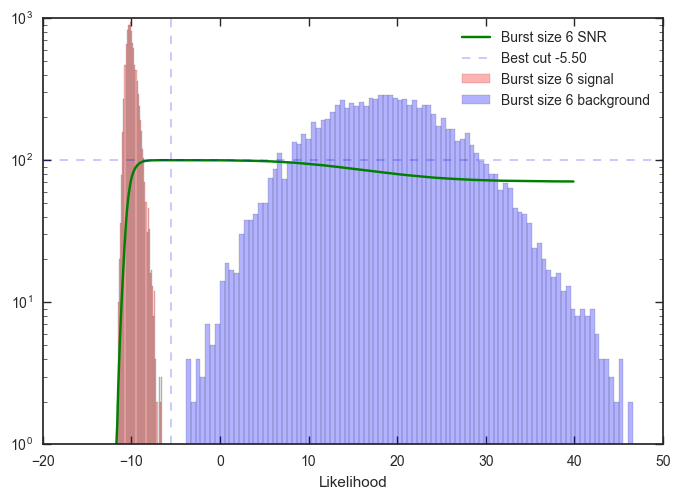

Cut for burst size 6 is -5.50


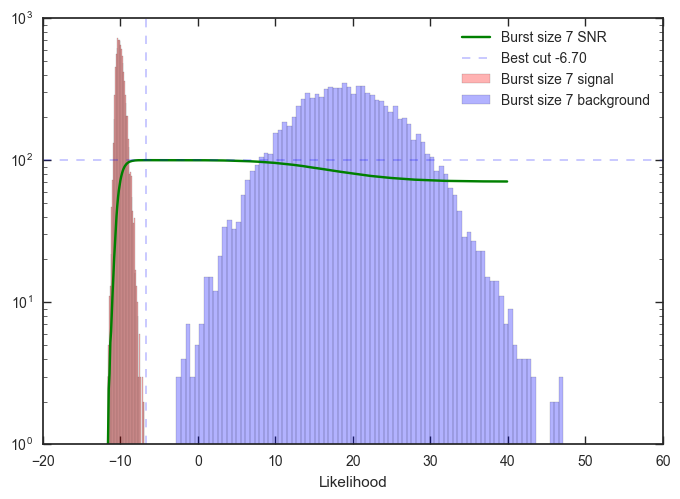

Cut for burst size 7 is -6.70


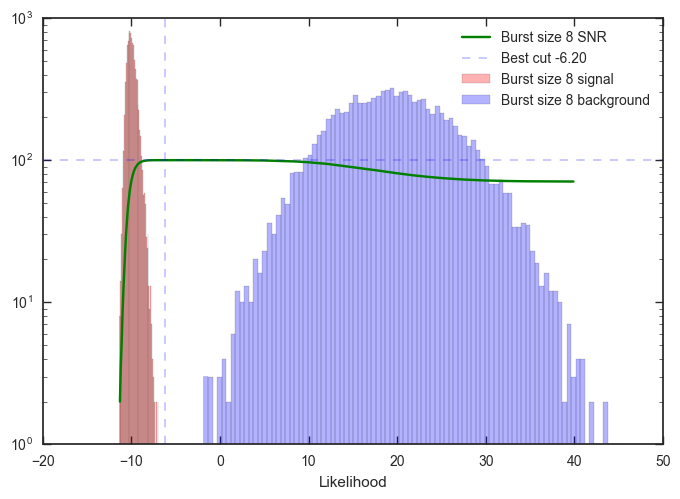

Cut for burst size 8 is -6.20


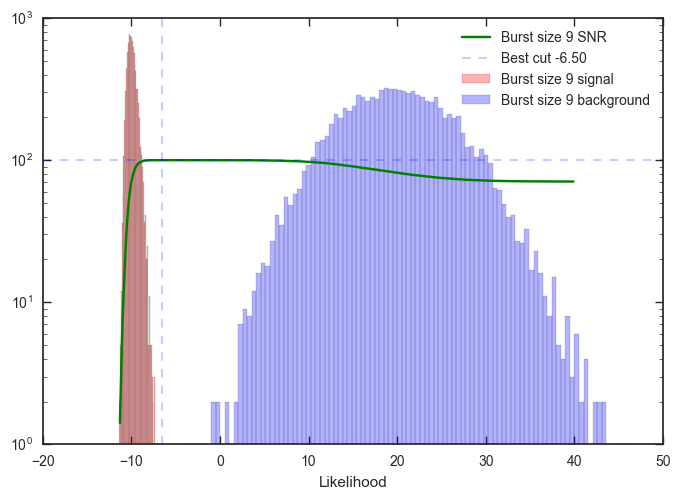

Cut for burst size 9 is -6.50


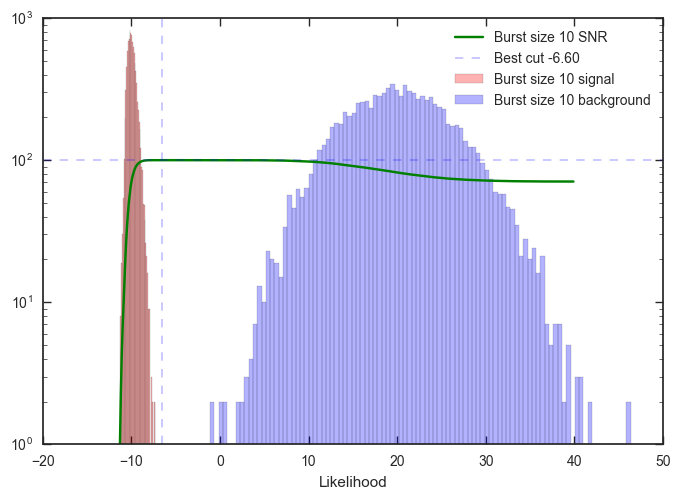

Cut for burst size 10 is -6.60


In [24]:
for N_burst in range(2,11):
    best_cut2 = opt_cut(Nsim=10000, N_burst=N_burst)
    print("Cut for burst size {0} is {1:.2f}".format(N_burst, best_cut2))

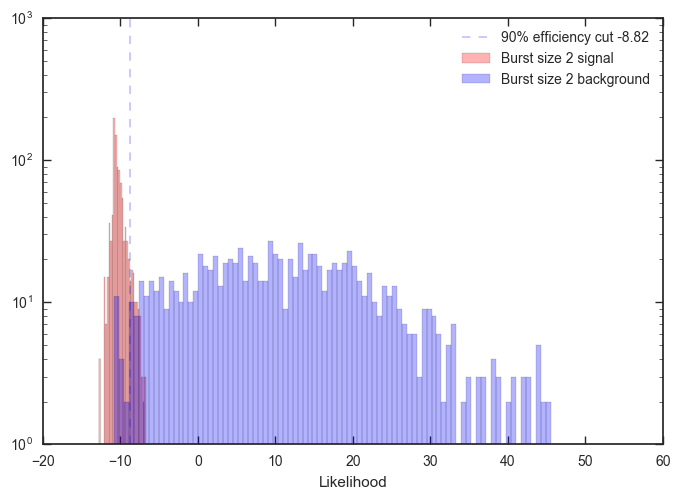

Cut at 90% efficiency for burst size 2 is -8.82


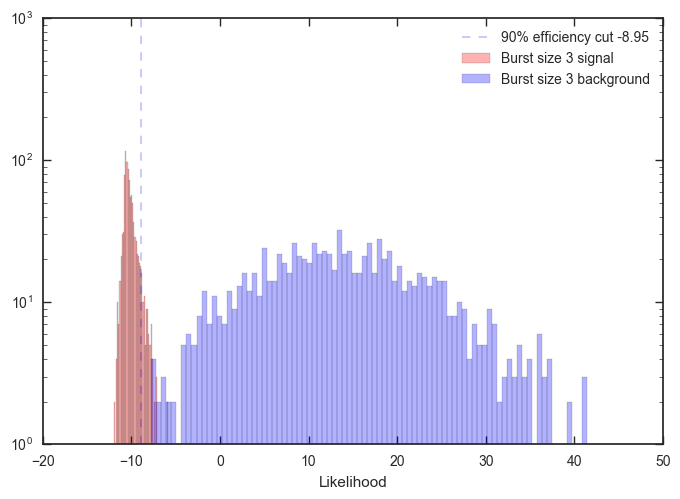

Cut at 90% efficiency for burst size 3 is -8.95


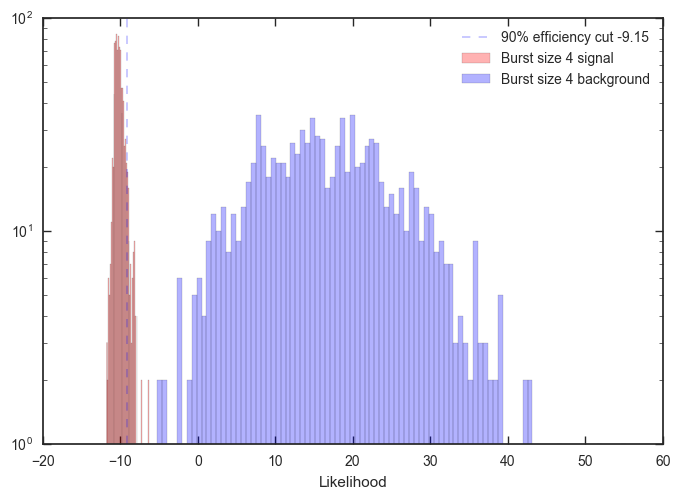

Cut at 90% efficiency for burst size 4 is -9.15


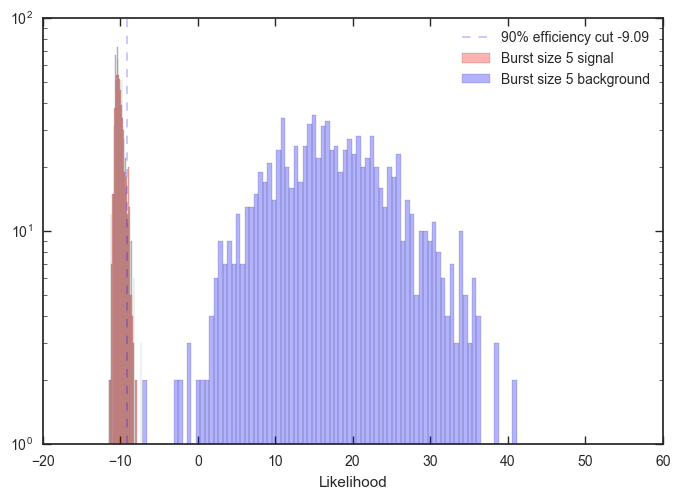

Cut at 90% efficiency for burst size 5 is -9.09


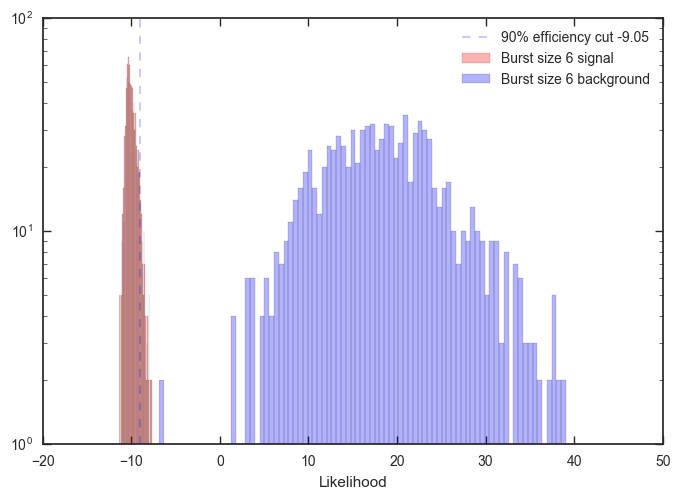

Cut at 90% efficiency for burst size 6 is -9.05


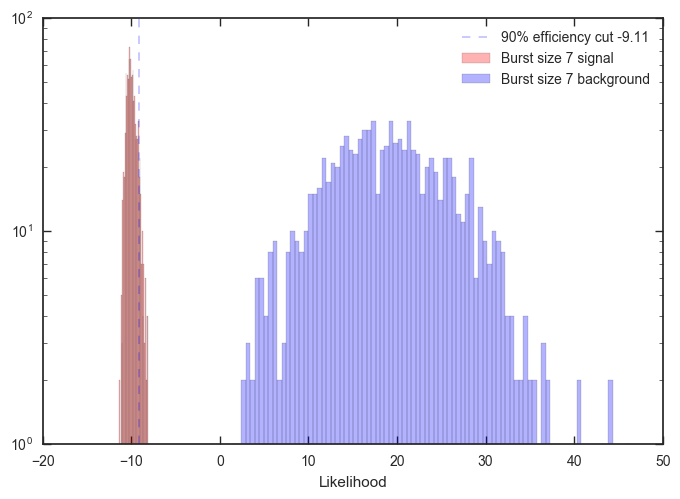

Cut at 90% efficiency for burst size 7 is -9.11


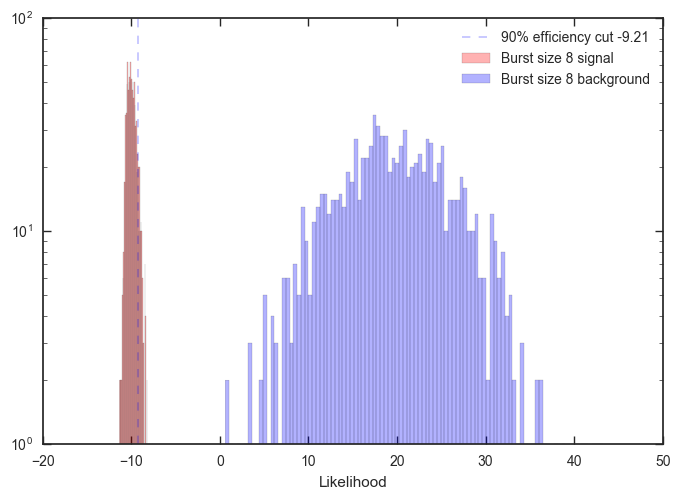

Cut at 90% efficiency for burst size 8 is -9.21


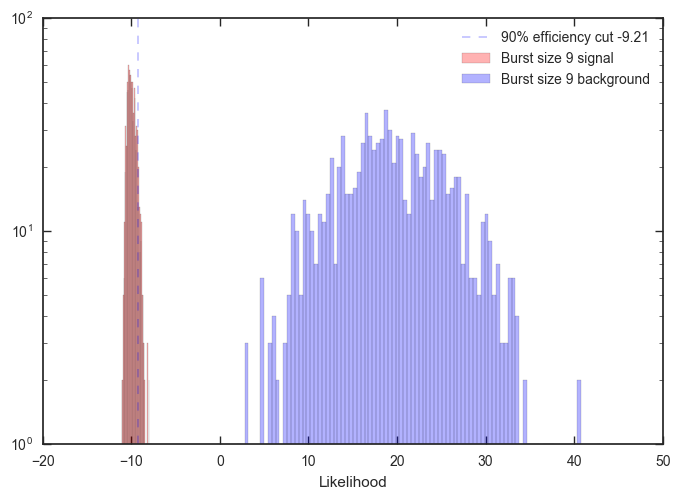

Cut at 90% efficiency for burst size 9 is -9.21


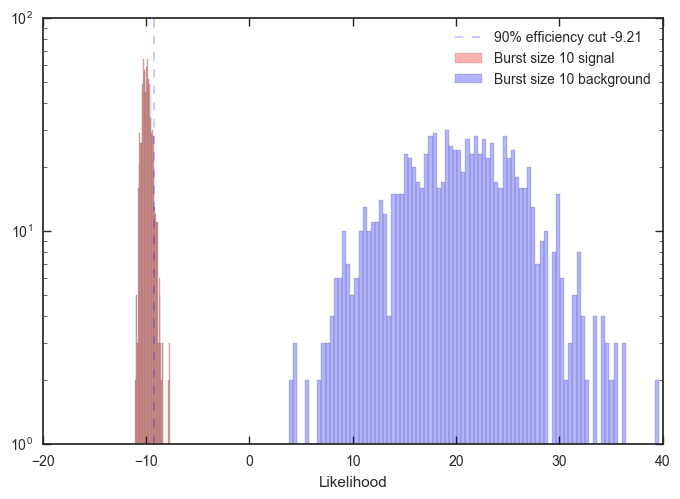

Cut at 90% efficiency for burst size 10 is -9.21


In [41]:
def eff_cut(Nsim=10000, N_burst=3):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, sig_bins=50, bkg_bins=100, ylog=True)
    ll_cuts=np.arange(-15,40,0.1)
    best_cut = cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_90efficiency_sim"+str(Nsim)+"_burst_size"+str(N_burst)+".png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


for N_burst in range(2,11):
    best_cut2 = eff_cut(Nsim=1000, N_burst=N_burst)
    print("Cut at 90% efficiency for burst size {0} is {1:.2f}".format(N_burst, best_cut2))
    

/Users/qifeng/Data/pbh/pbh.py:408: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:408: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


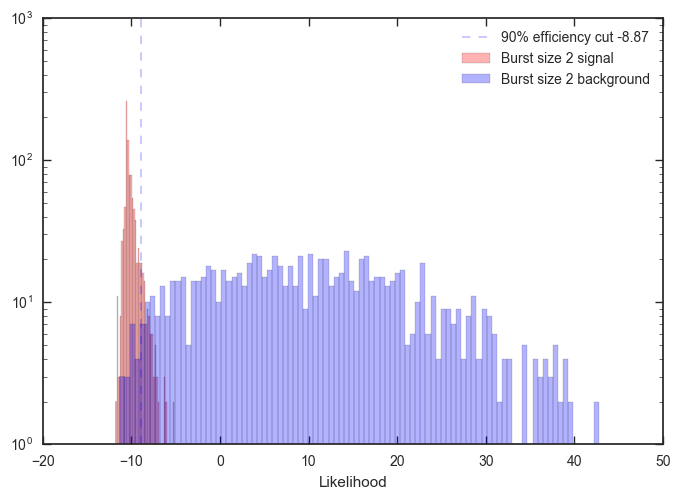

Cut at 90% efficiency for burst size 2 at EL 60 deg is -8.87


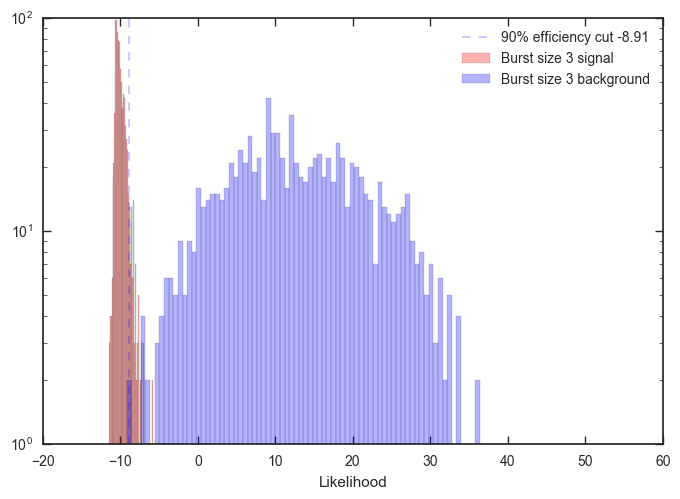

Cut at 90% efficiency for burst size 3 at EL 60 deg is -8.91


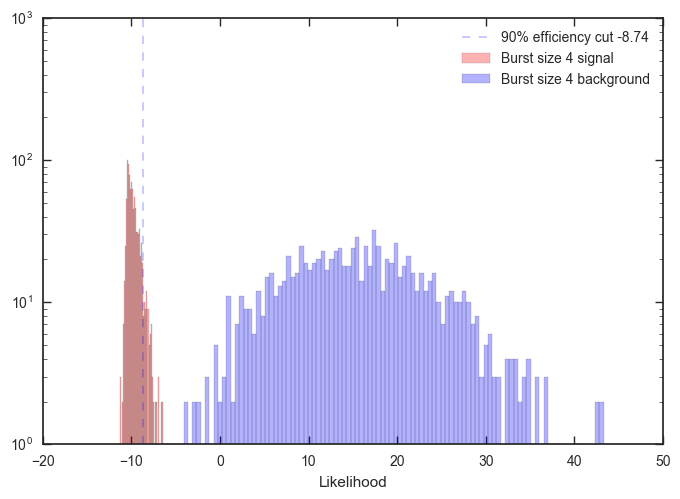

Cut at 90% efficiency for burst size 4 at EL 60 deg is -8.74


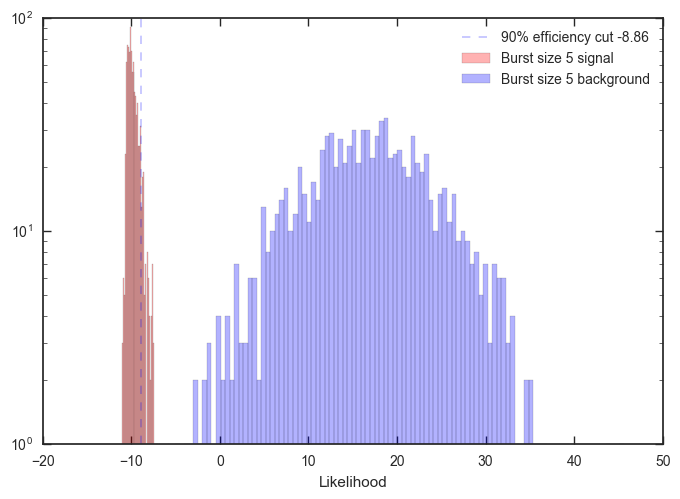

Cut at 90% efficiency for burst size 5 at EL 60 deg is -8.86


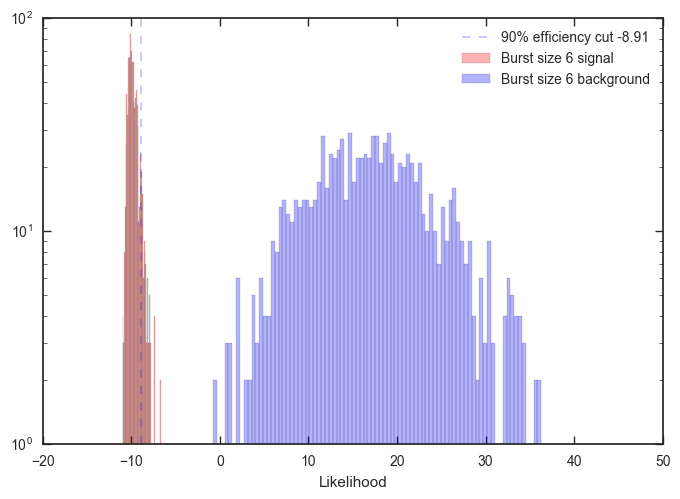

Cut at 90% efficiency for burst size 6 at EL 60 deg is -8.91


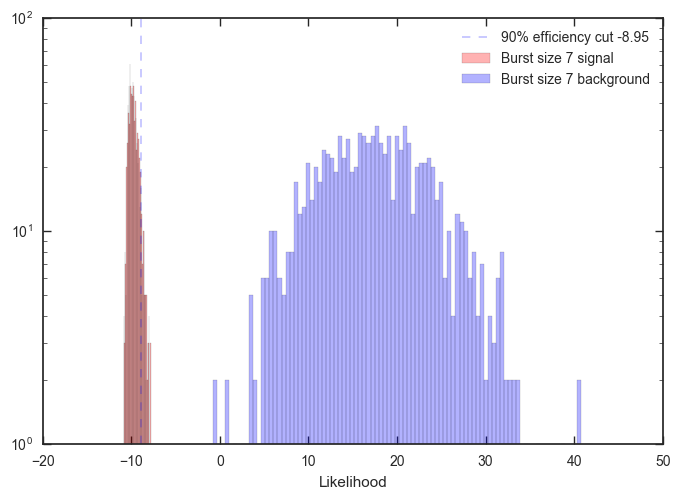

Cut at 90% efficiency for burst size 7 at EL 60 deg is -8.95


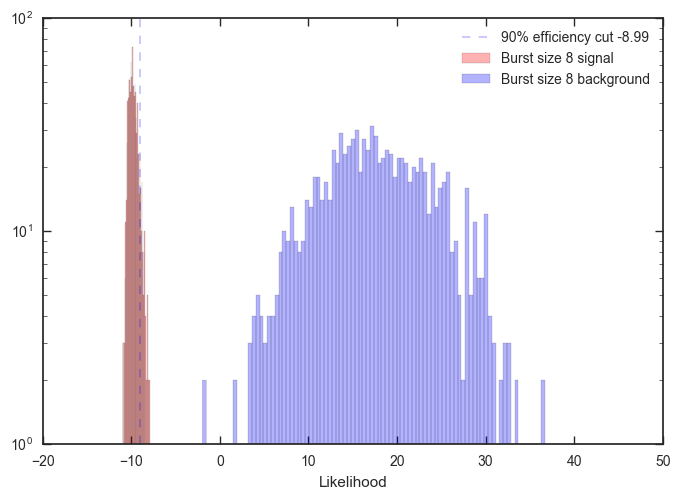

Cut at 90% efficiency for burst size 8 at EL 60 deg is -8.99


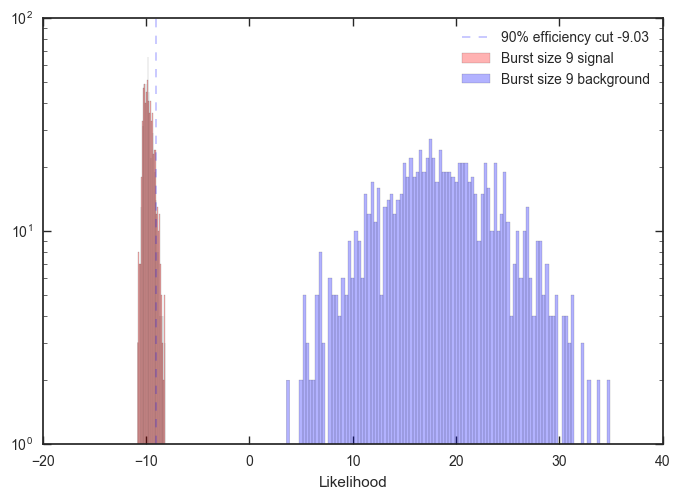

Cut at 90% efficiency for burst size 9 at EL 60 deg is -9.03


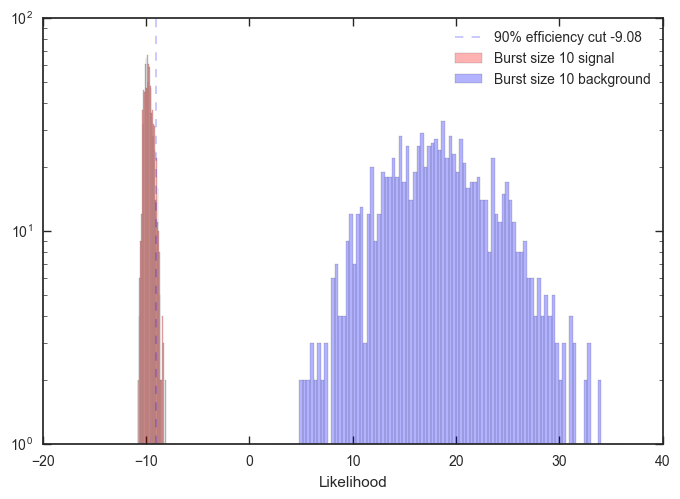

Cut at 90% efficiency for burst size 10 at EL 60 deg is -9.08


In [19]:
def eff_cut(Nsim=10000, N_burst=3):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, 
                                                filename=None, sig_bins=50, bkg_bins=100, 
                                                ylog=True, EL=60)
    ll_cuts=np.arange(-15,40,0.1)
    best_cut = cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_90efficiency_sim"+str(Nsim)+"_burst_size"+str(N_burst)+"EL60deg.png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


for N_burst in range(2,11):
    best_cut2 = eff_cut(Nsim=1000, N_burst=N_burst)
    print("Cut at 90% efficiency for burst size {0} at EL 60 deg is {1:.2f}".format(N_burst, best_cut2))
    
    

# Use RA=0 Dec=0 so that cos(Dec) = 1 

/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


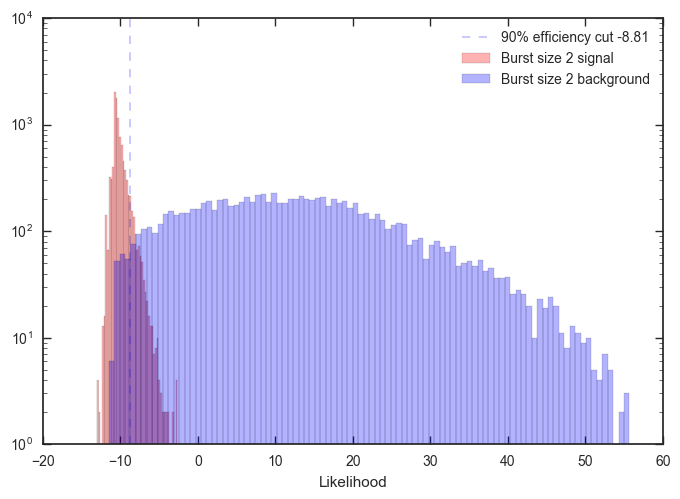

Cut at 90% efficiency at Dec 0 for burst size 2 is -8.81


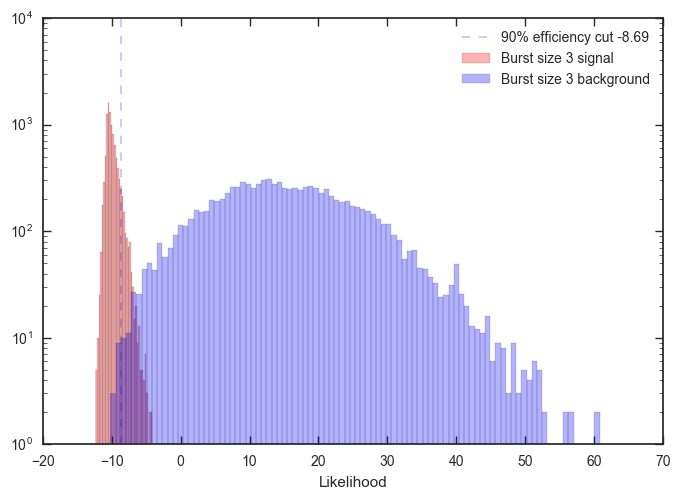

Cut at 90% efficiency at Dec 0 for burst size 3 is -8.69


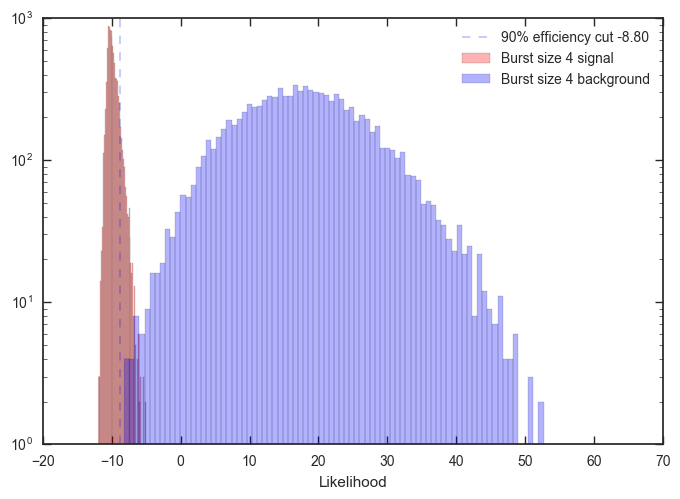

Cut at 90% efficiency at Dec 0 for burst size 4 is -8.80


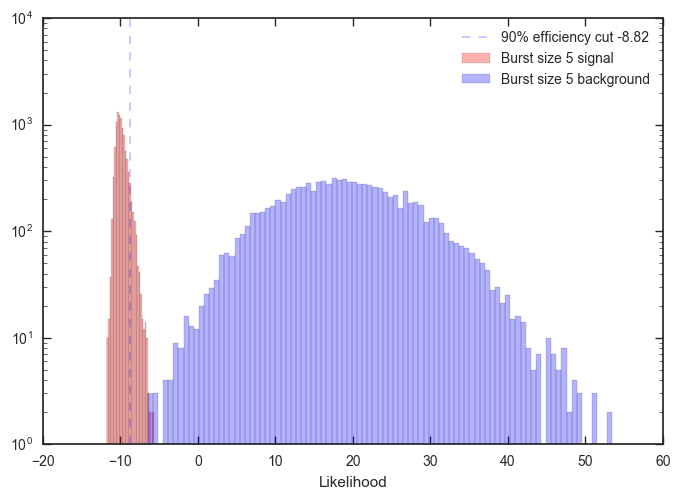

Cut at 90% efficiency at Dec 0 for burst size 5 is -8.82


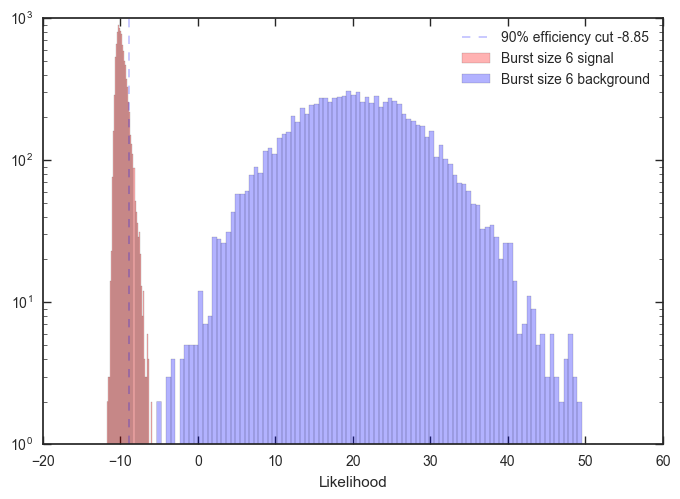

Cut at 90% efficiency at Dec 0 for burst size 6 is -8.85


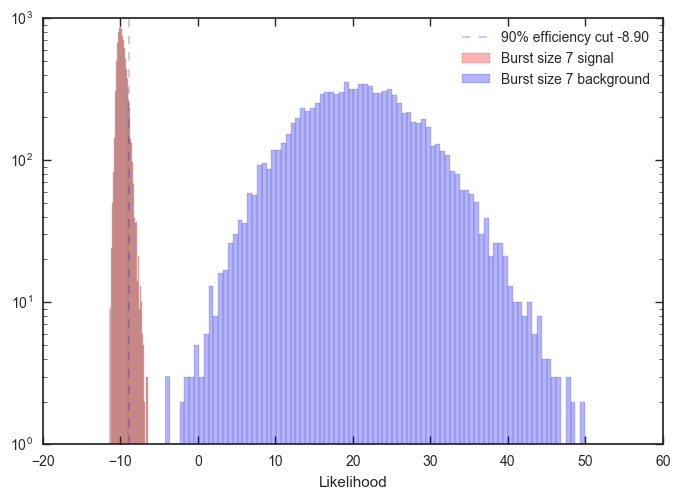

Cut at 90% efficiency at Dec 0 for burst size 7 is -8.90


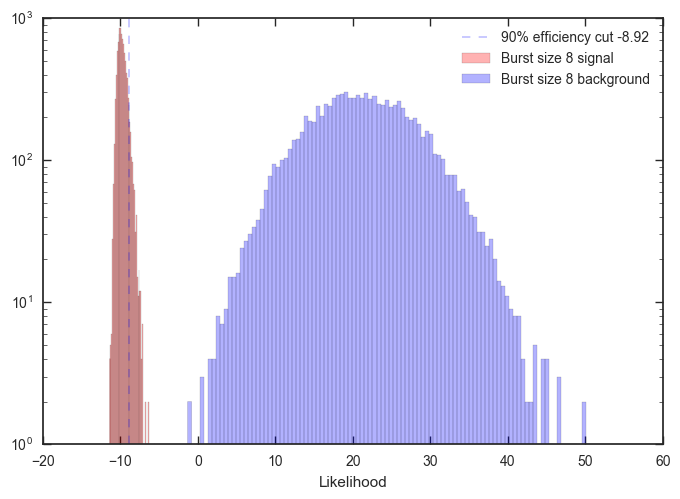

Cut at 90% efficiency at Dec 0 for burst size 8 is -8.92


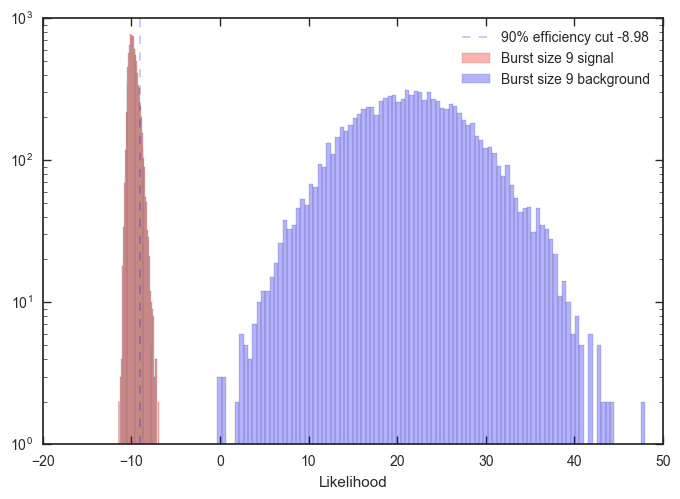

Cut at 90% efficiency at Dec 0 for burst size 9 is -8.98


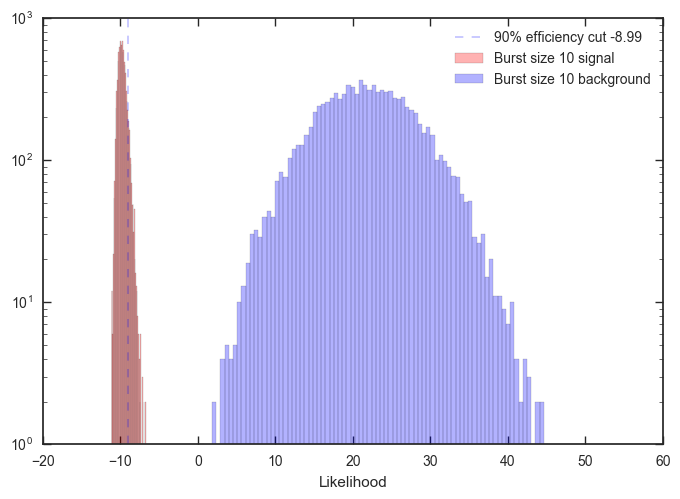

Cut at 90% efficiency at Dec 0 for burst size 10 is -8.99


In [6]:

def eff_cut00(Nsim=10000, N_burst=3):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, 
                                                sig_bins=50, bkg_bins=100, ylog=True, 
                                                fov_center = np.array([0., 0.0]))
    ll_cuts=np.arange(-15,40,0.1)
    best_cut = cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_90efficiency_sim"+str(Nsim)+"_burst_size"+str(N_burst)+"_RA0Dec0_v2.png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


for N_burst in range(2,11):
    best_cut2 = eff_cut00(Nsim=10000, N_burst=N_burst)
    print("Cut at 90% efficiency at Dec 0 for burst size {0} is {1:.2f}".format(N_burst, best_cut2))




# Same as above, EL = 75

/Users/qifeng/Data/pbh/pbh.py:409: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:409: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


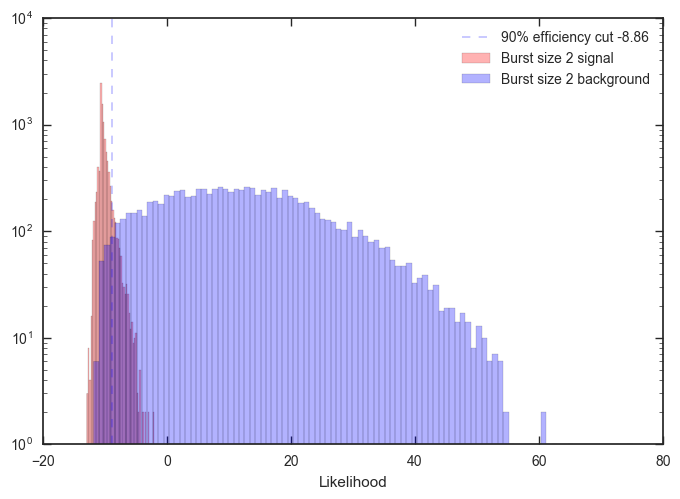

Cut at 90% efficiency for burst size 2 is -8.86


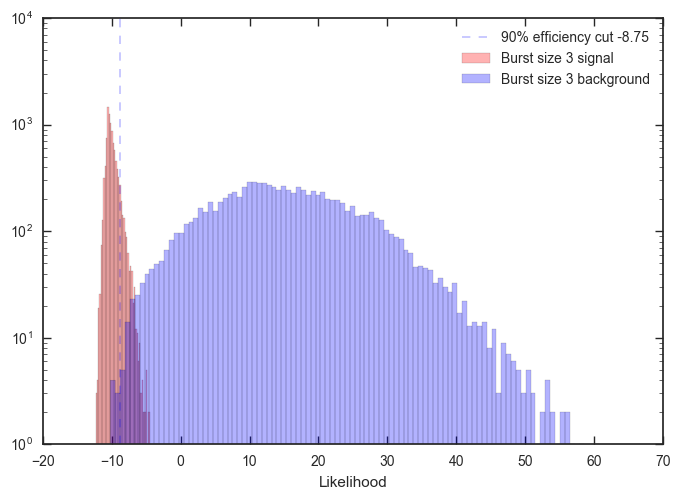

Cut at 90% efficiency for burst size 3 is -8.75


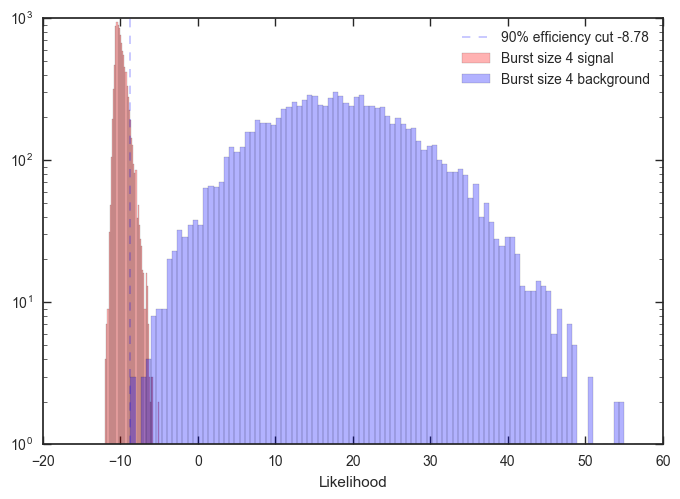

Cut at 90% efficiency for burst size 4 is -8.78


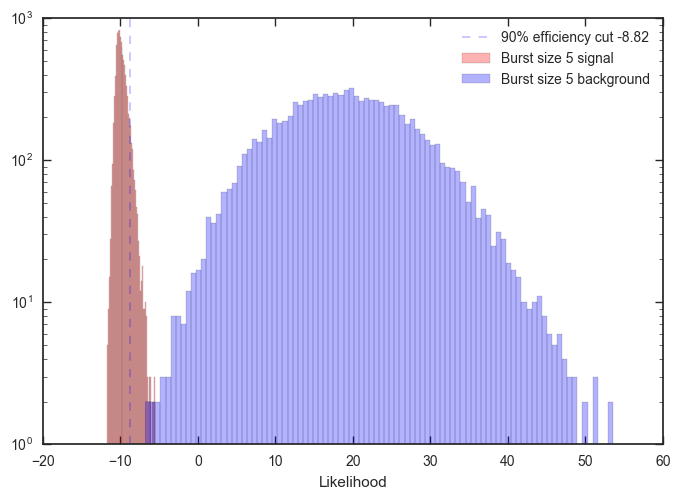

Cut at 90% efficiency for burst size 5 is -8.82


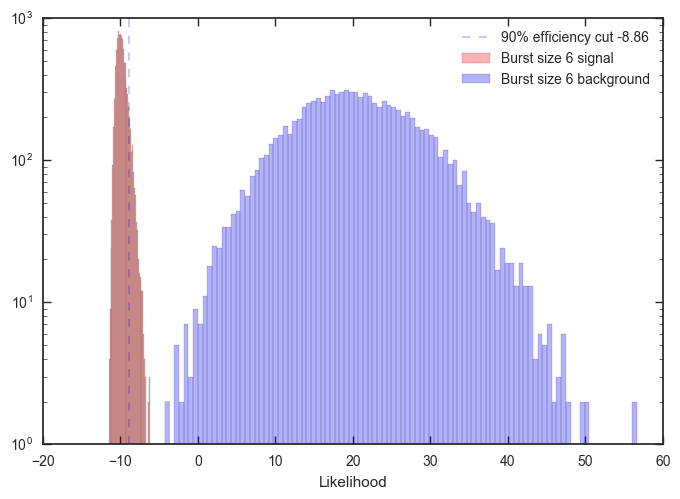

Cut at 90% efficiency for burst size 6 is -8.86


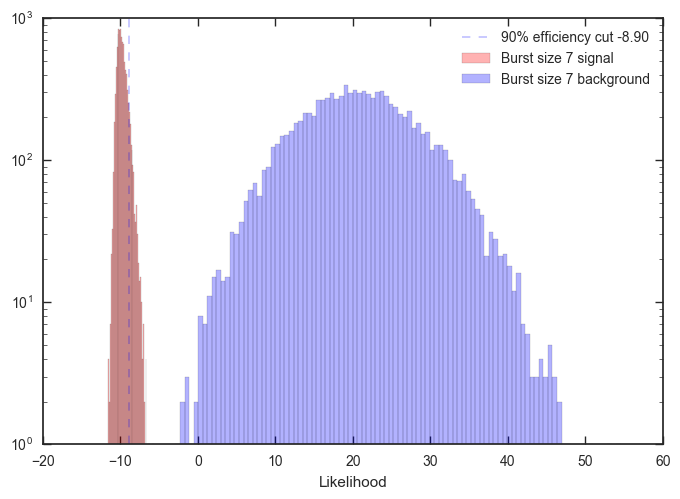

Cut at 90% efficiency for burst size 7 is -8.90


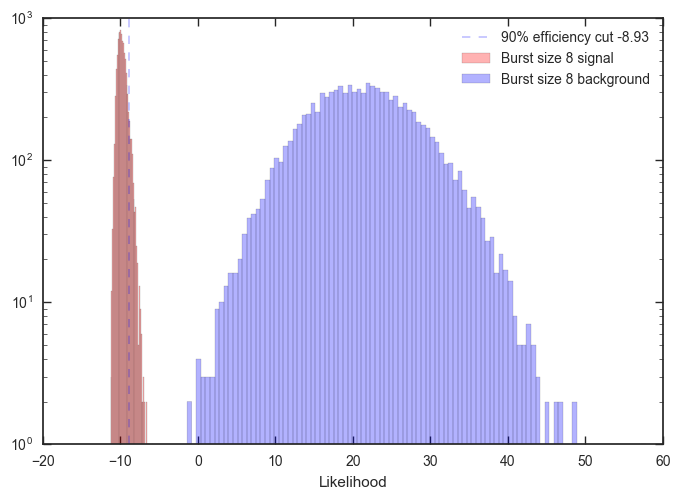

Cut at 90% efficiency for burst size 8 is -8.93


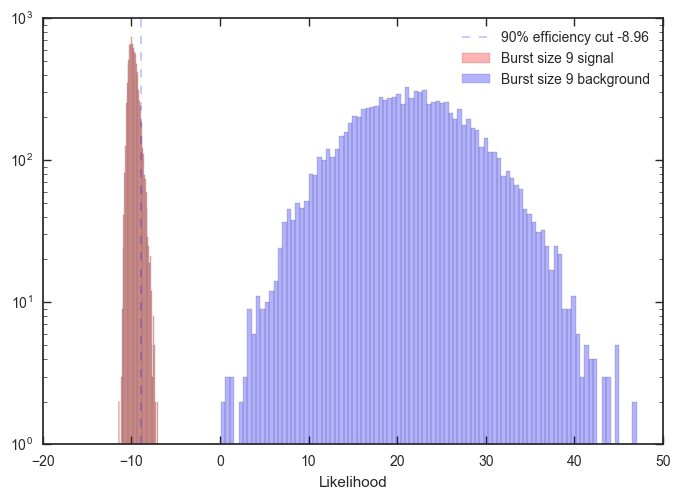

Cut at 90% efficiency for burst size 9 is -8.96


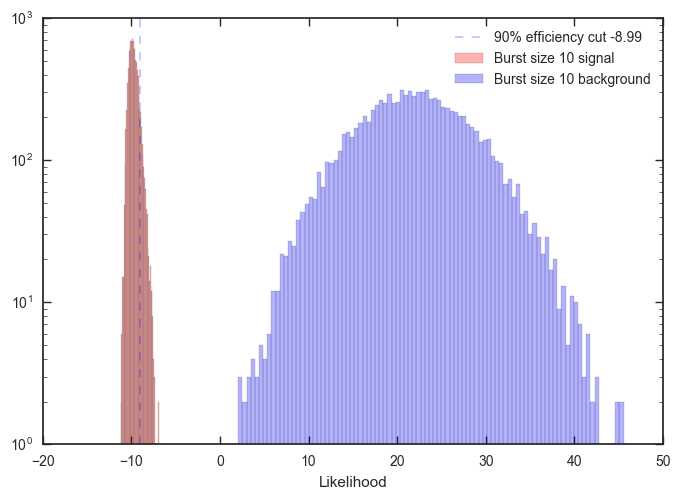

Cut at 90% efficiency for burst size 10 is -8.99


In [8]:

def eff_cut00(Nsim=10000, N_burst=3):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, 
                                                sig_bins=50, bkg_bins=100, ylog=True, EL=75, 
                                                fov_center = np.array([0., 0.0]))
    ll_cuts=np.arange(-15,-3,0.05)
    best_cut = cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_90efficiency_sim"+str(Nsim)+"_burst_size"+str(N_burst)+"_RA0Dec0EL75.png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


for N_burst in range(2,11):
    best_cut00_75 = eff_cut00(Nsim=10000, N_burst=N_burst)
    print("Cut at 90% efficiency for burst size {0} is {1:.2f}".format(N_burst, best_cut00_75))





# Dec = 80

/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


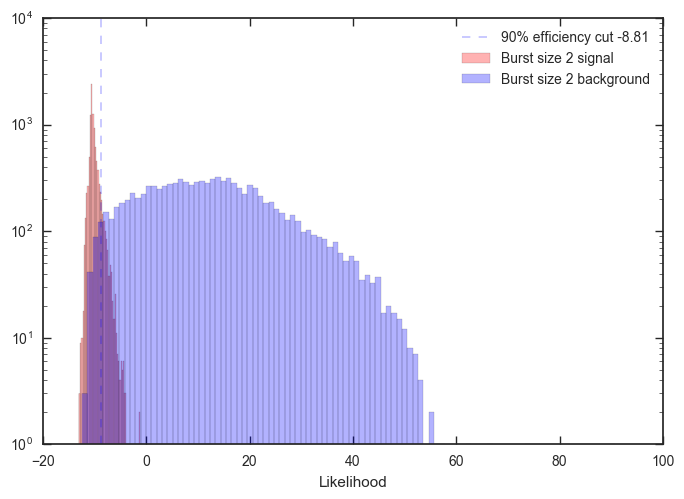

Cut at 90% efficiency at Dec 80 is for burst size 2 is -8.81


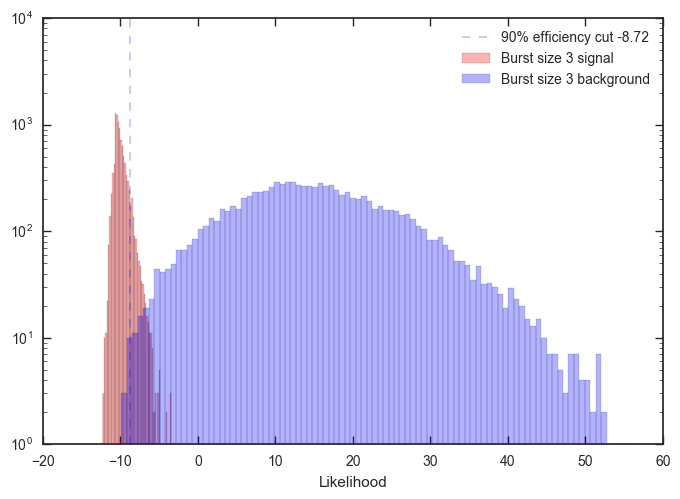

Cut at 90% efficiency at Dec 80 is for burst size 3 is -8.72


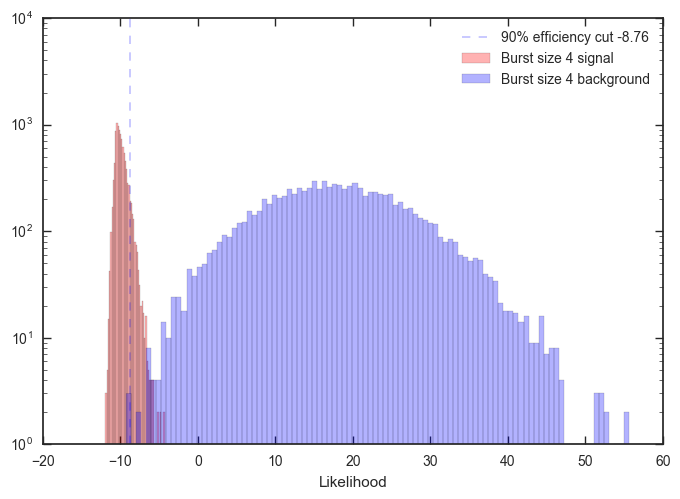

Cut at 90% efficiency at Dec 80 is for burst size 4 is -8.76


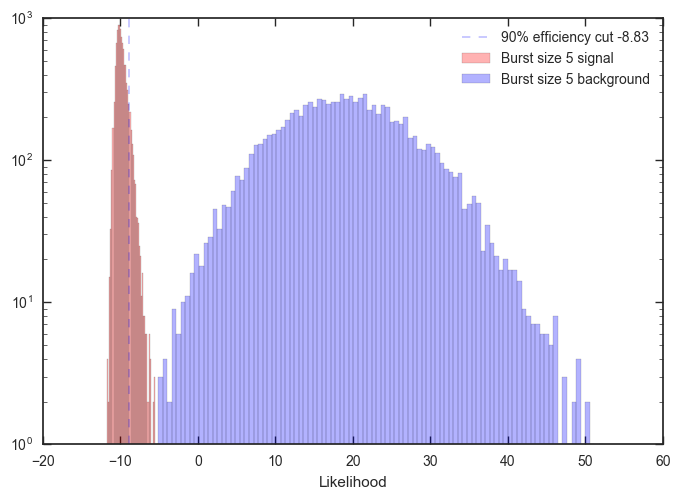

Cut at 90% efficiency at Dec 80 is for burst size 5 is -8.83


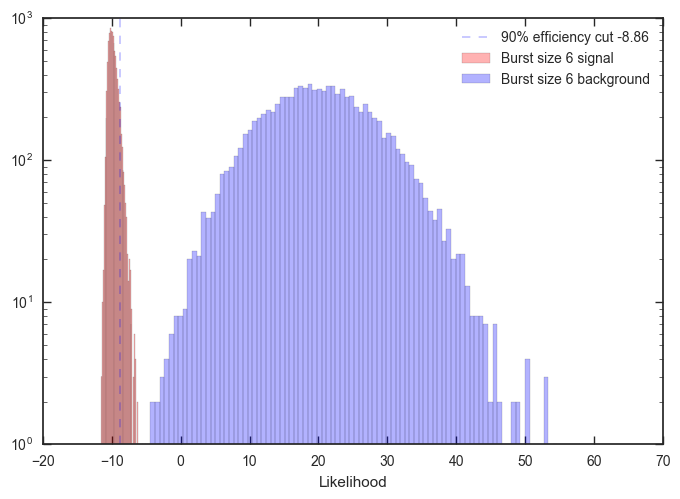

Cut at 90% efficiency at Dec 80 is for burst size 6 is -8.86


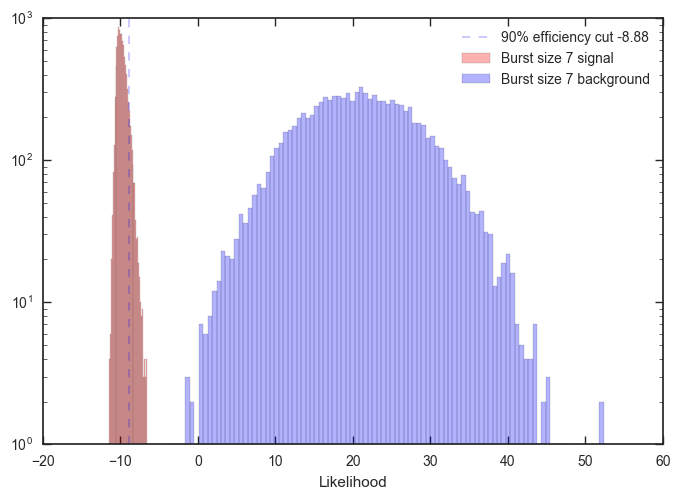

Cut at 90% efficiency at Dec 80 is for burst size 7 is -8.88


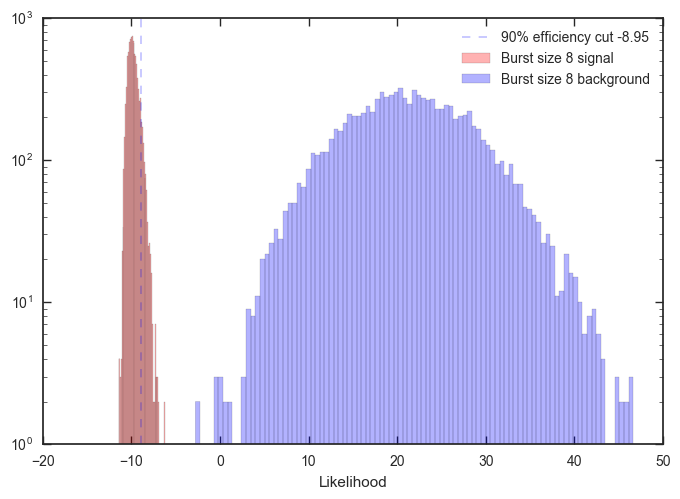

Cut at 90% efficiency at Dec 80 is for burst size 8 is -8.95


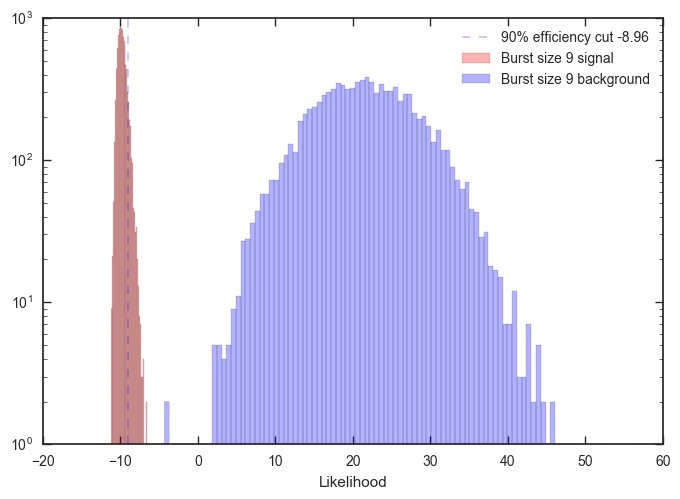

Cut at 90% efficiency at Dec 80 is for burst size 9 is -8.96


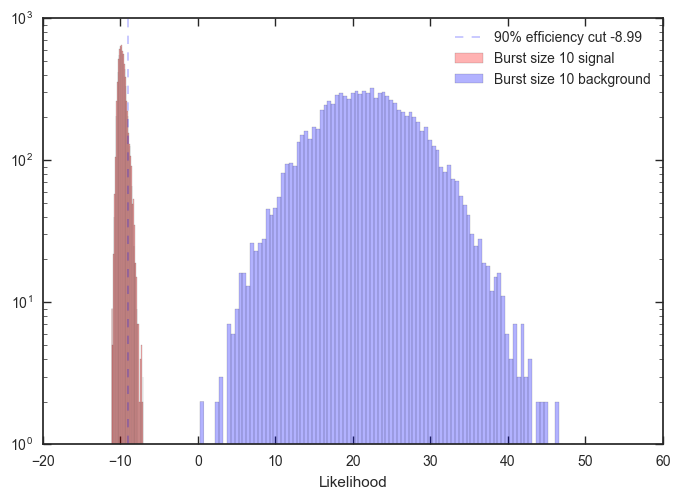

Cut at 90% efficiency at Dec 80 is for burst size 10 is -8.99


In [8]:
def eff_cut(Nsim=10000, N_burst=3, fov_center = np.array([100., 80.0])):
    ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, 
                                                sig_bins=50, bkg_bins=100, ylog=True, EL=75, 
                                                fov_center = fov_center)
    ll_cuts=np.arange(-15,-3,0.05)

    best_cut = cut_90efficiency(ll_sig_all, ll_bkg_all, ll_cuts, 
                                  label="Burst size "+str(N_burst), 
                                  outfile="psf_likelihood_cut_90efficiency_sim"+str(Nsim)+"_burst_size"+str(N_burst)+"_RA110Dec80EL75_v2.png")
    return best_cut
    #sigs = cut_optimize(ll_sig_all, ll_bkg_all, ll_cuts, ylog=False)


for N_burst in range(2,11):
    best_cut110_80 = eff_cut(Nsim=10000, N_burst=N_burst, fov_center = np.array([110., 80.0]))
    print("Cut at 90% efficiency at Dec 80 is for burst size {0} is {1:.2f}".format(N_burst, best_cut110_80))



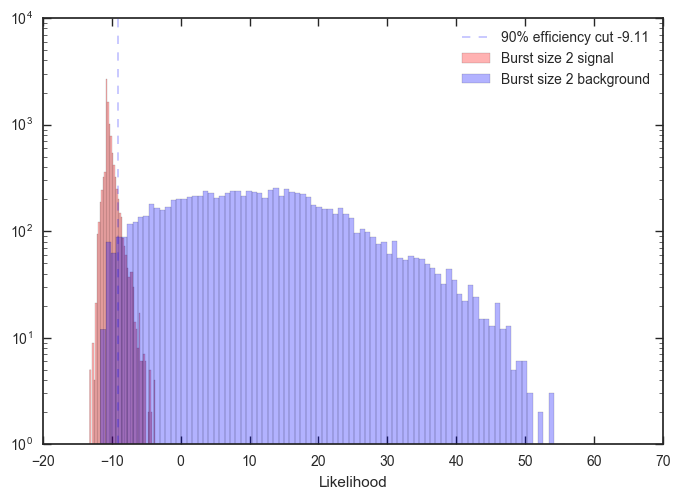

Cut at 90% efficiency for burst size 2 is -9.11


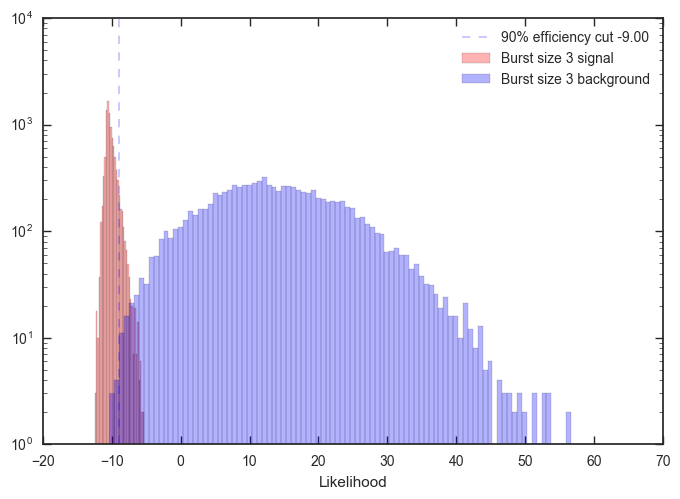

Cut at 90% efficiency for burst size 3 is -9.00


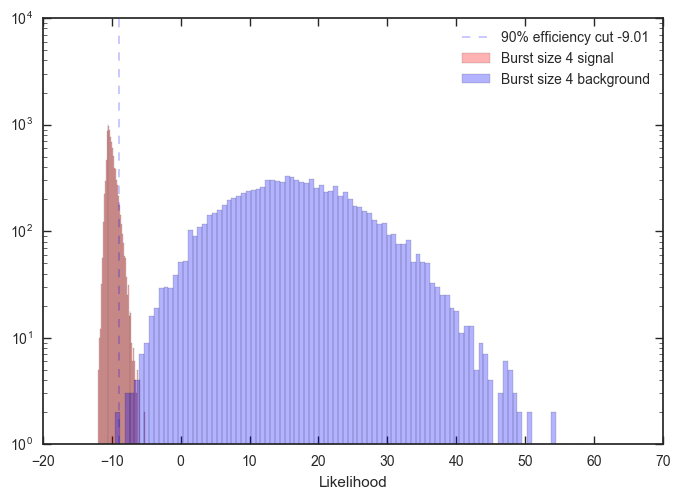

Cut at 90% efficiency for burst size 4 is -9.01


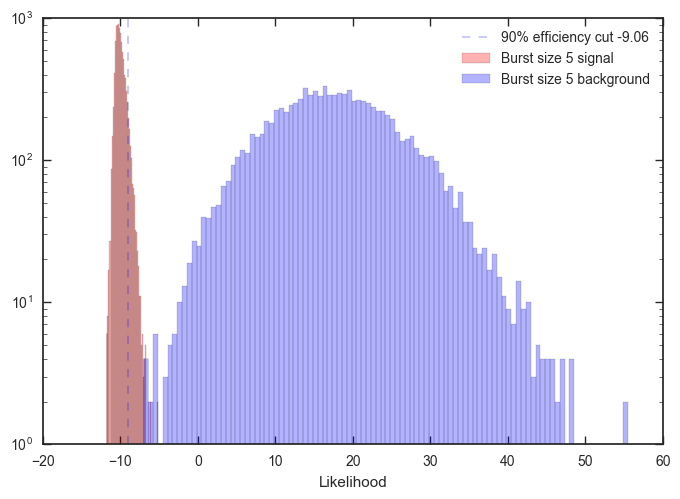

Cut at 90% efficiency for burst size 5 is -9.06


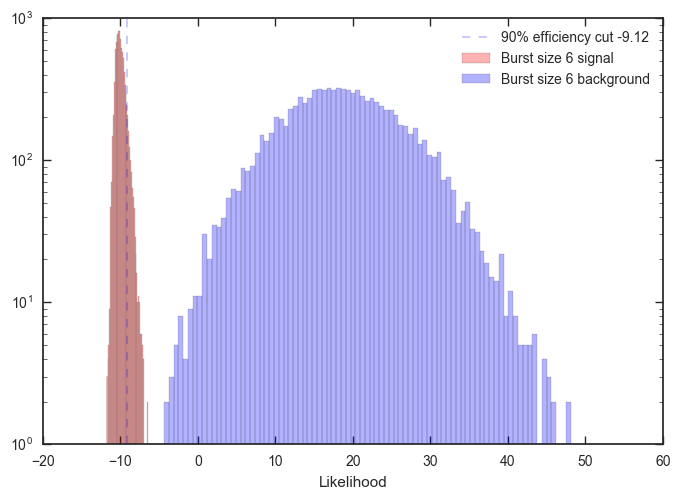

Cut at 90% efficiency for burst size 6 is -9.12


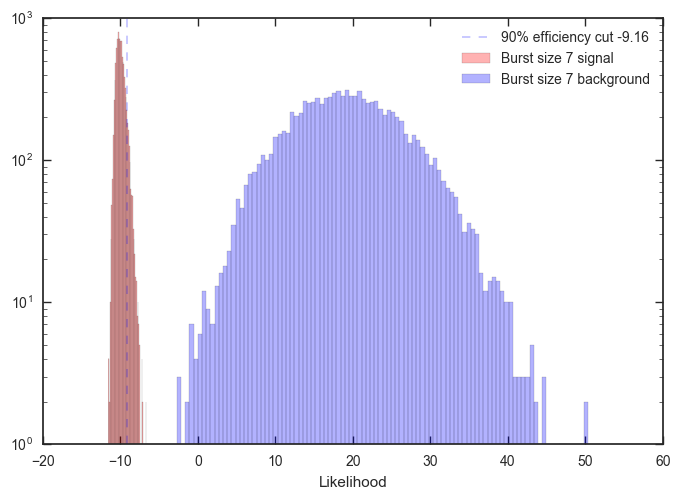

Cut at 90% efficiency for burst size 7 is -9.16


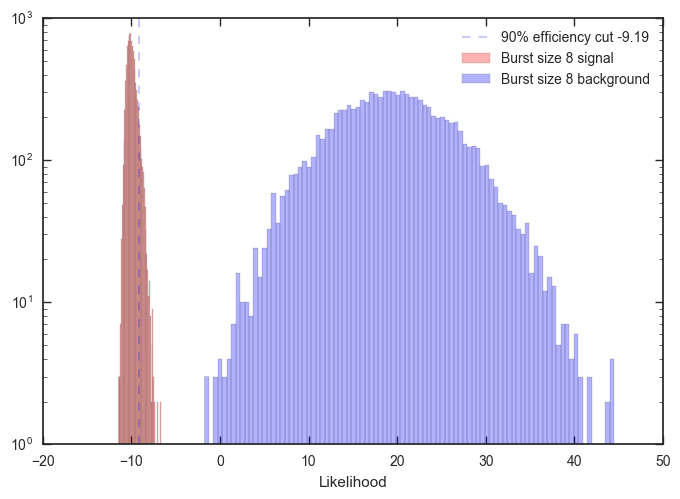

Cut at 90% efficiency for burst size 8 is -9.19


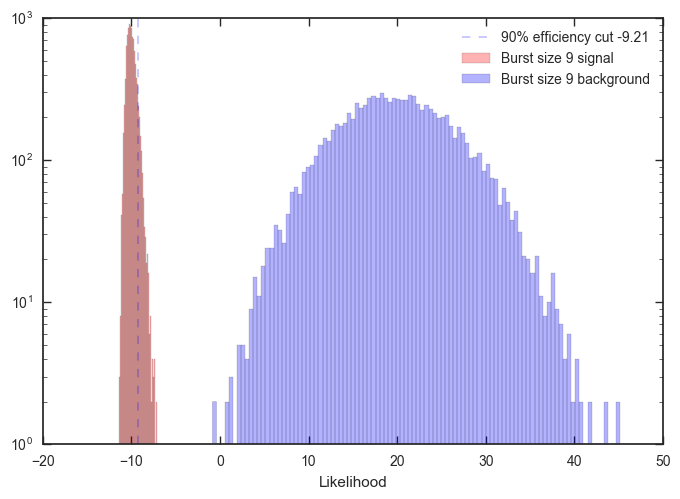

Cut at 90% efficiency for burst size 9 is -9.21


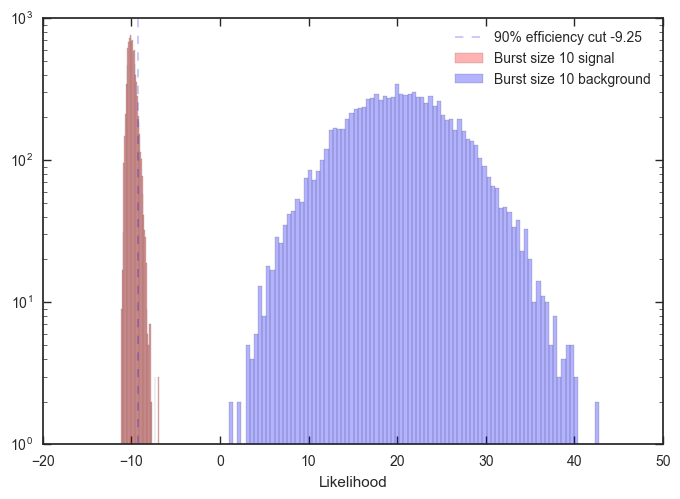

Cut at 90% efficiency for burst size 10 is -9.25


In [42]:
for N_burst in range(2,11):
    best_cut2 = eff_cut(Nsim=10000, N_burst=N_burst)
    print("Cut at 90% efficiency for burst size {0} is {1:.2f}".format(N_burst, best_cut2))
    

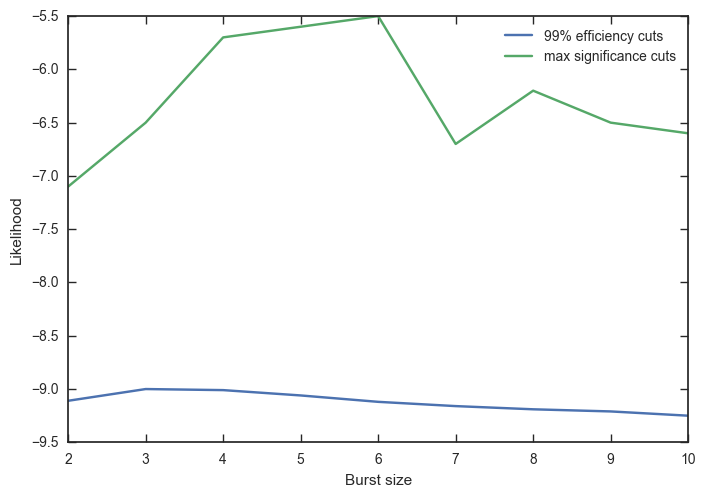

In [19]:
burst_sizes = np.array([2,3,4,5,6,7,8,9,10])
cuts_eff = np.array([-9.11,-9.00,-9.01, -9.06, -9.12, -9.16, -9.19, -9.21, -9.25])
cuts_optimal = np.array([-7.1,-6.5,-5.7,-5.6,-5.5,-6.7,-6.2,-6.5, -6.6])
plt.plot(burst_sizes, cuts_eff, label="99% efficiency cuts")
plt.plot(burst_sizes, cuts_optimal, label="max significance cuts")
plt.xlabel("Burst size")
plt.ylabel("Likelihood")
plt.legend()
plt.savefig("psf_likelihood_cuts_vs_burst_sizes.png", dpi=300)


In [11]:
def sim_cut_90efficiency(NMC=50, Nsim=2000, N_burst=3, upper=True, plot=True, outfile=None, 
                         EL = 75, fov_center = np.array([180., 30.0]), 
                         cut_bins=50, ylog=False):
    cuts = np.zeros(NMC).astype('float')
    for trial in range(NMC):
        ll_sig_all, ll_bkg_all = sim_psf_likelihood(Nsim=Nsim, N_burst=N_burst, filename=None, 
                                                    EL = EL, fov_center = fov_center, 
                                                    sig_bins=50, bkg_bins=100, ylog=True)
        ll_cuts=np.arange(-15,40,0.05)
        label="Burst size "+str(N_burst) + ", Dec {:.0f}".format(fov_center[1])
        #for i, c in enumerate(ll_cuts):
        #    sig = calc_cut_sig(ll_sig_all, ll_bkg_all, c, upper=upper)
        #    sigs[i] = sig
        best_cut = np.percentile(ll_sig_all, 90)
        cuts[trial] = best_cut
    if plot:
        plt.hist(cuts, bins=cut_bins, color='r', alpha=0.3, label=str(label) + " sim cuts")
        #plt.axvline(x=best_cut, ls="--", lw=0.3, label="90% efficiency cut {:.2f}".format(best_cut))
        plt.legend(loc='best')
        plt.xlabel("Likelihood")
        if ylog:
            plt.yscale('log')
        if outfile is not None:
            plt.savefig(outfile)
        plt.show()    
    return cuts




/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


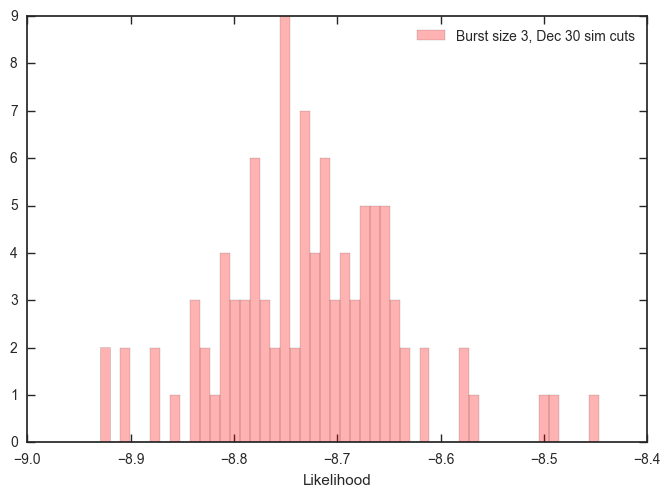

In [11]:
sim_cuts_Dec30 = sim_cut_90efficiency(NMC=100, Nsim=1000, N_burst=3, 
                                      fov_center = np.array([180., 30.0]), outfile="sim_cuts_distr_bs3_Dec30.png")



/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


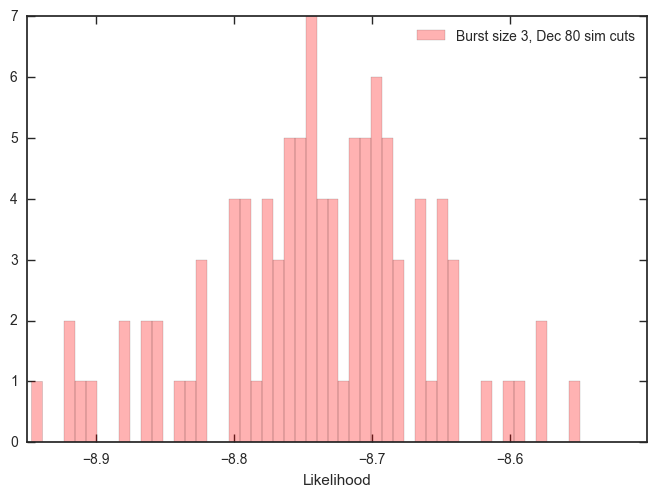

In [12]:
sim_cuts_Dec80 = sim_cut_90efficiency(NMC=100, Nsim=1000, N_burst=3, 
                                      fov_center = np.array([180., 80.0]), outfile="sim_cuts_distr_bs3_Dec80.png")



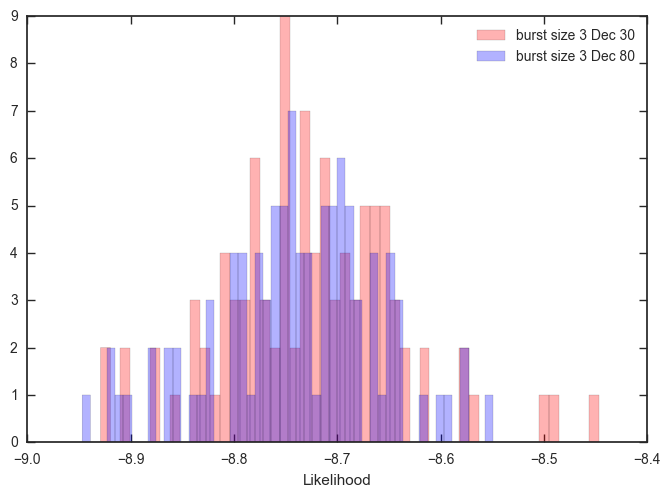

In [13]:

plt.hist(sim_cuts_Dec30, bins=50, color='r', alpha=0.3, label="burst size 3 Dec 30")
plt.hist(sim_cuts_Dec80, bins=50, color='b', alpha=0.3, label="burst size 3 Dec 80")

plt.legend(loc='best')
plt.xlabel("Likelihood")
plt.show()    




/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


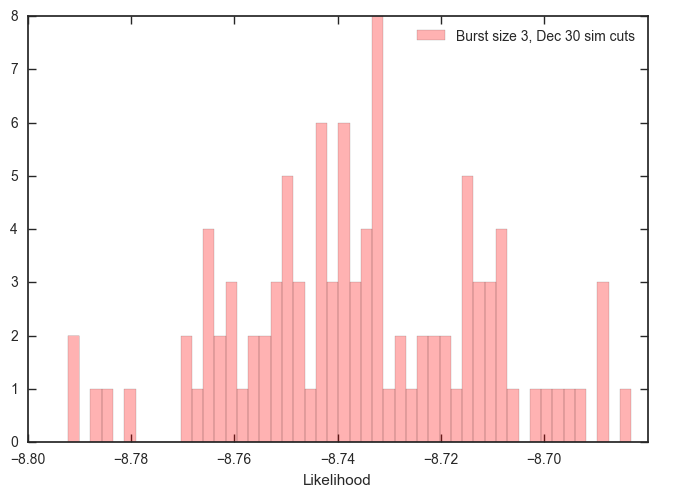

In [14]:
sim_cuts_Dec30_10k = sim_cut_90efficiency(NMC=100, Nsim=10000, N_burst=3, 
                                      fov_center = np.array([180., 30.0]), 
                                      outfile="sim_cuts_distr_bs3_Dec30_10ksims.png")



/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:426: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


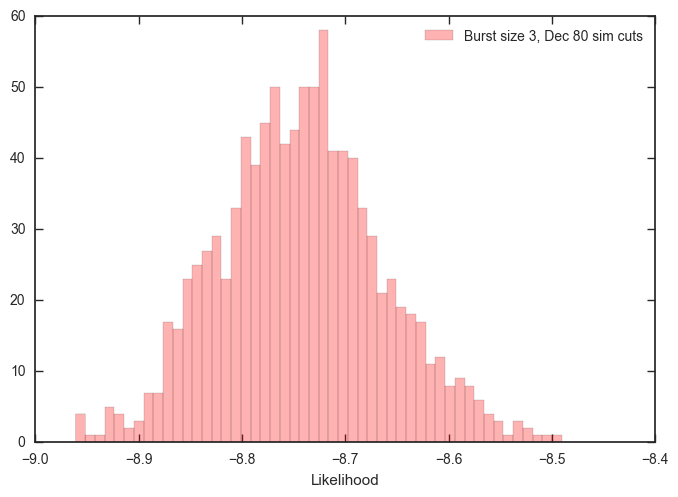

In [15]:
sim_cuts_Dec80_10k = sim_cut_90efficiency(NMC=1000, Nsim=1000, N_burst=3, 
                                      fov_center = np.array([180., 80.0]), 
                                      outfile="sim_cuts_distr_bs3_Dec80_1Msims.png")




In [ ]:
cut_list = []
for bs_ in range(2,10):
    sim_cuts_Dec80_ = sim_cut_90efficiency(NMC=1000, Nsim=1000, N_burst=bs_, 
                                      fov_center = np.array([180., 80.0]), 
                                      outfile="sim_cuts_distr_bs"+str(bs_)+"_Dec80_1Msims.png")
    np.save("sim_cuts_distr_bs"+str(bs_)+"_Dec80_1Msims.npy", sim_cuts_Dec80_)
    cut_list.append(sim_cuts_Dec80_)
    




/Users/qifeng/Data/pbh/pbh.py:430: RuntimeWarning: overflow encountered in cosh
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
/Users/qifeng/Data/pbh/pbh.py:430: RuntimeWarning: divide by zero encountered in log
  ll = -2. * np.sum(np.log(psfs)) + np.sum(np.log(1. / np.cosh(np.sqrt(theta2s) / psfs)))
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [9]:
sim_cuts3 = sim_cut_90efficiency(NMC=100, Nsim=1000, N_burst=3, outfile="sim_cuts_distr_burst_size3.png")


(100,)


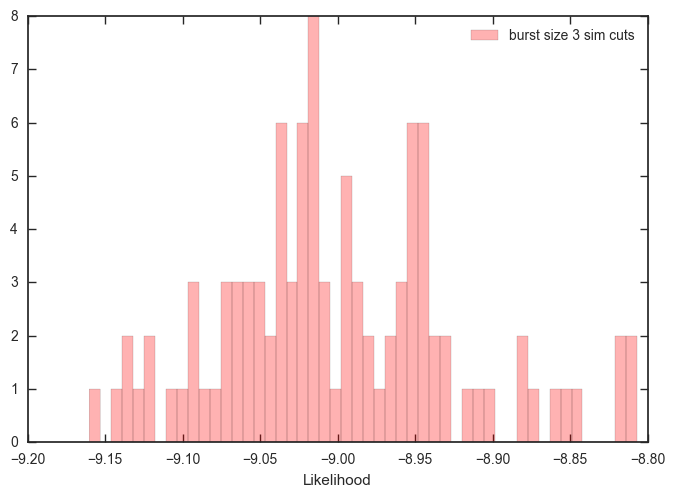

In [12]:
print(sim_cuts3.shape)

plt.hist(sim_cuts3, bins=50, color='r', alpha=0.3, label="burst size 3 sim cuts")
plt.legend(loc='best')
plt.xlabel("Likelihood")
plt.show()    



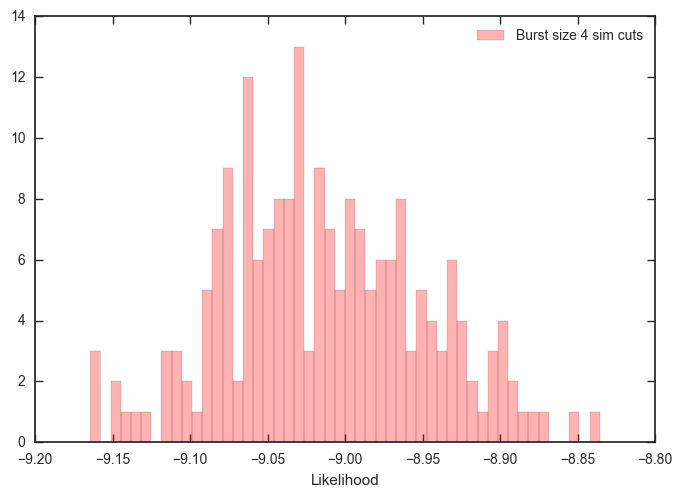

In [13]:
sim_cuts4 = sim_cut_90efficiency(NMC=200, Nsim=1000, N_burst=4, plot=True, outfile="sim_cuts_distr_burst_size4_200sims.png")



In [20]:
ll_cut_dict = {2:-9.11,3:-9.00,4:-9.01, 5:-9.06, 6:-9.12, 7:-9.16, 8:-9.19, 9:-9.21, 10:-9.25}

In [23]:

2 in ll_cut_dict.keys()

True

In [8]:
def get_angular_distance(coord1, coord2):
        """
        coord1 and coord2 are in [ra, dec] format in degrees
        """
        return rad2deg(np.arccos(np.sin(deg2rad(coord1[1])) * np.sin(deg2rad(coord2[1]))
                                 + np.cos(deg2rad(coord1[1])) * np.cos(deg2rad(coord2[1])) *
                                 np.cos(deg2rad(coord1[0]) - deg2rad(coord2[0]))))
    
    

def get_angular_distance_h(coord1, coord2):
    ra1 = coord1[0] 
    dec1 = coord1[1]
    ra2 = coord2[0] 
    dec2 = coord2[1]
    
    delt_lon = (ra1 - ra2)*np.pi/180.
    delt_lat = (dec1 - dec2)*np.pi/180.
    # Haversine formula
    dist = 2.0*np.arcsin( np.sqrt( np.sin(delt_lat/2.0)**2 + \
           np.cos(dec1*np.pi/180.)*np.cos(dec2*np.pi/180.)*np.sin(delt_lon/2.0)**2 ) )  

    return dist/np.pi*180.


def get_angular_distance_small_angle(coord1, coord2):
        """
        coord1 and coord2 are in [ra, dec] format in degrees
        """
        return rad2deg(np.sqrt(((deg2rad(coord1[0] - coord2[0])*np.cos(deg2rad(coord1[1])))**2 + 
                       (deg2rad(coord1[1] - coord2[1]))**2)))
                                 
    

def gen_one_random_coords_projected_plane(cent_coord, theta):
        """
        *** Here use small angle approx, as it is only a sanity check ***
        :return a pair of uniformly random RA and Dec at theta deg away from the cent_coord
        """
        # the dec of this small circle should be in the range of [cent_dec - theta, cent_dec + theta]
        delta_dec = (np.random.random() * 2. -1.) * theta
        _dec = cent_coord[1] + delta_dec
        # Note that dec is 90 deg - theta in spherical coordinates
        _ra = cent_coord[0] + rad2deg( np.arccos ( np.cos(deg2rad(theta)) * (1./np.cos(deg2rad(90.-cent_coord[1]))) * (1./np.cos(deg2rad(90.-_dec))) \
                                                   - np.tan(deg2rad(90.-cent_coord[1])) *  np.tan(deg2rad(90.-_dec)) ) )
        return np.array([_ra, _dec])


def gen_one_random_coords(cent_coord, theta):
        """
        *** Here use small angle approx, as it is only a sanity check ***
        :return a pair of uniformly random RA and Dec at theta deg away from the cent_coord
        """
        _phi = np.random.random() * np.pi * 2.
        #_ra = cent_coord[0] + np.sin(_phi) * theta
        _ra = cent_coord[0] + np.sin(_phi) * theta / np.cos(cent_coord[1])
        _dec = cent_coord[1] + np.cos(_phi) * theta
        return np.array([_ra, _dec])


def gen_one_random_coords_wrong(cent_coord, theta):
        """
        *** Here use small angle approx, as it is only a sanity check ***
        :return a pair of uniformly random RA and Dec at theta deg away from the cent_coord
        """
        _phi = np.random.random() * np.pi * 2.
        _ra = cent_coord[0] + np.sin(_phi) * theta
        #_ra = cent_coord[0] + np.sin(_phi) * theta / np.cos(cent_coord[1])
        _dec = cent_coord[1] + np.cos(_phi) * theta
        return np.array([_ra, _dec])






In [6]:
get_angular_distance(np.array([100., 60.0]), np.array([103., 61.0]))



1.7836413435121148

In [7]:
get_angular_distance_small_angle(np.array([100., 60.0]), np.array([103., 61.0]))



1.802775637731995

In [9]:
def plot_skymap(self, coords, Es, ELs, ax=None, color='r', fov_center=None, fov=1.75, fov_color='gray',
                    cent_coords=None, cent_marker='+', cent_ms=1.8, cent_mew=4.0, cent_radius=0.01, cent_color='b',
                    label=None, projection=None):
        if ax is None:
            fig = plt.figure(figsize=(5, 5))
            if projection is not None:
                #ax = plt.subplot(111, projection="aitoff")
                ax = plt.subplot(111, projection=projection)
            else:
                ax = plt.subplot(111)
        ax.plot(coords[:, 0], coords[:, 1], color + '.')
        label_flag = False
        for coor, E_, EL_ in zip(coords, Es, ELs):
            if label_flag == False:
                circ = plt.Circle(coor, radius=self.get_psf(E_, EL_), color=color, fill=False, label=label)
                label_flag = True
            else:
                circ = plt.Circle(coor, radius=self.get_psf(E_, EL_), color=color, fill=False)
            ax.add_patch(circ)

        label_flag = False
        if fov is not None and fov_center is not None:
            circ_fov = plt.Circle(fov_center, radius=fov, color=fov_color, fill=False)
            ax.add_patch(circ_fov)
            ax.set_xlim(fov_center[0] - fov * 1.1, fov_center[0] + fov * 1.1)
            ax.set_ylim(fov_center[1] - fov * 1.1, fov_center[1] + fov * 1.1)
        if cent_coords is not None:
            #circ_cent=plt.Circle(cent_coords, radius=cent_radius, color=cent_color, fill=False)
            #ax.add_patch(circ_cent)
            ax.plot(cent_coords[0], cent_coords[1], marker=cent_marker, ms=cent_ms, markeredgewidth=cent_mew,
                    color=color)

        plt.legend(loc='best')
        ax.set_xlabel('RA')
        ax.set_ylabel("Dec")
        return ax


def plot_coords(ras, decs, fov_center = np.array([108.2, 59.1]), projection="aitoff"):
    pbh = Pbh()
    
    #ras = (np.random.random(size=10)-0.5) * 1.5 + fov_center[0]
    #decs = (np.random.random(size=10)-0.5) * 1.5 + fov_center[1]
    coords = np.concatenate([ras.reshape(ras.shape[0], 1), decs.reshape(decs.shape[0], 1)], axis=1)
    psfs = np.ones(ras.shape[0]) * 0.05
    centroid, c_ll = pbh.minimize_centroid_ll(coords, psfs)

    print("RA, Dec = {}".format(centroid))
    #print(centroid.reshape(1, 2)[:, 0])
    #print(centroid.reshape(1, 2)[:, 1])
    print("log likelihood = {}".format(c_ll))

    
    print("========")
    coords_ra = np.concatenate([ras.reshape(ras.shape[0], 1), np.zeros((decs.shape[0], 1))], axis=1)
    centroid_ra, c_ll_ra = pbh.minimize_centroid_ll(coords_ra, psfs)
    #print(centroid_ra)
    #print(centroid_ra.reshape(1, 2)[:, 0])
    #print(centroid_ra.reshape(1, 2)[:, 1])
    print("ra log likelihood = {}".format(c_ll_ra))

    coords_dec = np.concatenate([np.zeros((ras.shape[0], 1)), decs.reshape(decs.shape[0], 1)], axis=1)
    centroid_dec, c_ll_dec = pbh.minimize_centroid_ll(coords_dec, psfs)
    #print(centroid_dec.reshape(1, 2)[:, 0])
    #print(centroid_dec.reshape(1, 2)[:, 1])
    print("dec log likelihood = {}".format(c_ll_dec))
    print("RA, Dec = {}, {}".format(centroid_ra[0], centroid_dec[1]))


    c_ll_combine = (c_ll_ra + c_ll_dec)/(2.*ras.shape[0]-2);
    print("combined log likelihood = {}".format(c_ll_combine))


    #ax = pbh.plot_skymap(coords, [0.1] * ras.shape[0], [0.2] * decs.shape[0])
    ax = plot_skymap(pbh, coords, [0.1] * ras.shape[0], [0.2] * decs.shape[0], projection=projection)
    
    if projection is None:
        ax1 = plt.gca()
        ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    #pbh.plot_skymap(centroid.reshape(1, 2), [0.1], [0.2], ax=ax, color='b', fov_center=fov_center)
    #plt.savefig("Centroid_test.png")
    plt.show()

    




In [10]:
theta=0.5

rand_sig_coords_test3 = np.zeros((10, 2))
rand_sig_coords_test4 = np.zeros((10, 2))

rand_sig_coords_test3_wrong = np.zeros((10, 2))
rand_sig_coords_test4_wrong = np.zeros((10, 2))

rand_sig_coords_test3_old = np.zeros((10, 2))
rand_sig_coords_test4_old = np.zeros((10, 2))


fov_center_test1 = np.array([100., 60.0])
fov_center_test2 = np.array([180., 30.0])

rand_sig_coords_offset = np.zeros((10, 2))
rand_sig_coords_offset_wrong = np.zeros((10, 2))


for i in range(10):
    #rand_sig_theta_test = pbh.gen_one_random_theta(0.05, prob="psf", fov=1.75)
    #rand_sig_coords_offset[i, :] = gen_one_random_coords(np.array([0., 0.0]), theta)
    #rand_sig_coords_offset_wrong[i, :] = gen_one_random_coords_wrong(np.array([0., 0.0]), theta)

    pbh=Pbh()
    rand_sig_coords_test3[i, :] = pbh.gen_one_random_coords(fov_center_test1, theta)
    rand_sig_coords_test4[i, :] = pbh.gen_one_random_coords(fov_center_test2, theta)
    
    #rand_sig_coords_test3[i, :] = fov_center_test1+rand_sig_coords_offset[i, :]
    #rand_sig_coords_test4[i, :] = fov_center_test2+rand_sig_coords_offset[i, :]

    rand_sig_coords_test3_wrong[i, :] = gen_one_random_coords_wrong(fov_center_test1, theta)
    rand_sig_coords_test4_wrong[i, :] = gen_one_random_coords_wrong(fov_center_test2, theta)
    #rand_sig_coords_test3_wrong[i, :] = fov_center_test1+rand_sig_coords_offset_wrong[i, :]
    #rand_sig_coords_test4_wrong[i, :] = fov_center_test2+rand_sig_coords_offset_wrong[i, :]
    
    #pbh=Pbh()
    #rand_sig_coords_test3_old[i, :] = pbh.gen_one_random_coords_old(fov_center_test1, theta)
    #rand_sig_coords_test4_old[i, :] = pbh.gen_one_random_coords_old(fov_center_test2, theta)

    print("========")
    print(get_angular_distance(rand_sig_coords_test3[i, :], fov_center_test1))
    print(get_angular_distance(rand_sig_coords_test3_wrong[i, :], fov_center_test1))
    #print(get_angular_distance(rand_sig_coords_test3_old[i, :], fov_center_test1))

    print("========")
    print(get_angular_distance(rand_sig_coords_test4[i, :], fov_center_test2))
    print(get_angular_distance(rand_sig_coords_test4_wrong[i, :], fov_center_test2))
    #print(get_angular_distance(rand_sig_coords_test4_old[i, :], fov_center_test2))








0.501447632335
0.367583457184
0.500253375459
0.49255801817
0.501394381276
0.457483028373
0.499548870674
0.458263595032
0.49861846897
0.498124459769
0.499995678696
0.448500777899
0.500022091105
0.452780315177
0.500440002131
0.47937058215
0.499831474094
0.422089262868
0.500285184218
0.44508439221
0.499962792669
0.38910993266
0.499917980478
0.499805171531
0.498563253697
0.254697293923
0.500331173546
0.448826997853
0.500673357122
0.492853085541
0.50001630146
0.490408567903
0.498542624349
0.315137920235
0.500015405322
0.444409037373
0.49985994389
0.286286841047
0.499527119942
0.477255448037


RA, Dec = [ 99.83333173  60.28755126]
log likelihood = 6.277376395277136
ra log likelihood = 8.320008017025902
dec log likelihood = 0.33258728336697363
RA, Dec = 99.8537715587129, 60.29112919683144
combined log likelihood = 0.48069973891071527


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


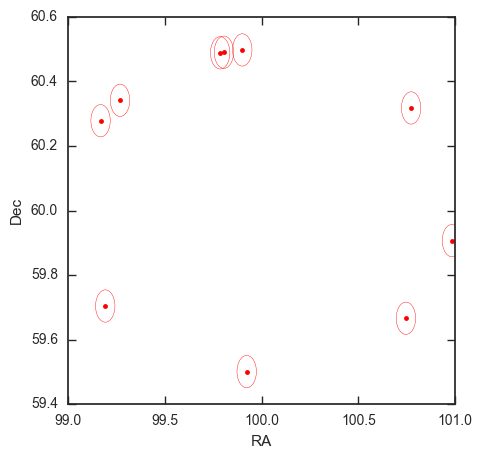

In [11]:
plot_coords(rand_sig_coords_test3[:,0],
            rand_sig_coords_test3[:,1], 
            fov_center = fov_center_test1, projection=None)




RA, Dec = [ 179.8788963   29.7858607]
log likelihood = 6.6729951249555715
ra log likelihood = -1.1582017591931246
dec log likelihood = 1.9525423356685336
RA, Dec = 179.8918358079917, 29.751225466128
combined log likelihood = 0.04413003202641161


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


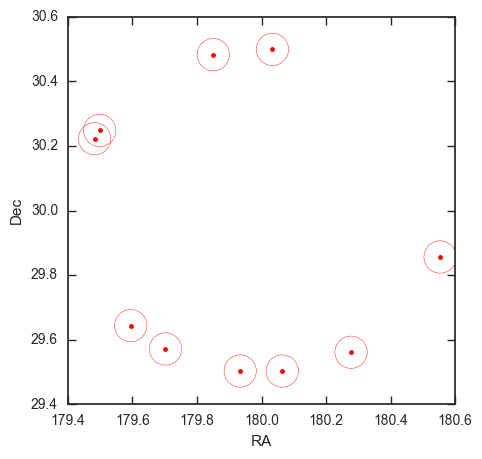

In [12]:
plot_coords(rand_sig_coords_test4[:,0],
            rand_sig_coords_test4[:,1], 
            fov_center = fov_center_test2, projection=None)




RA, Dec = [ 179.93864686   30.00038037]
log likelihood = 6.513158499473301
ra log likelihood = 0.5467240553397661
dec log likelihood = 1.5183466198108209
RA, Dec = 179.9274270787183, 29.999705653170007
combined log likelihood = 0.11472614861947705


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


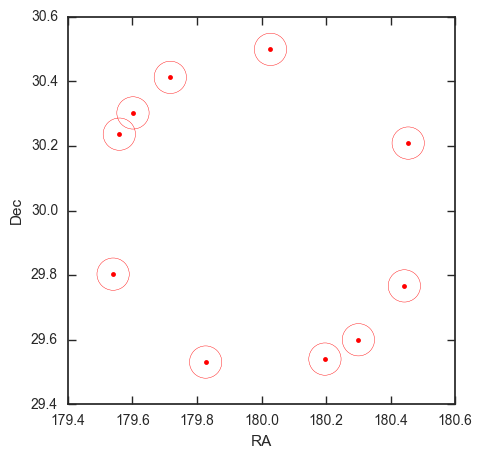

In [13]:
plot_coords(rand_sig_coords_test4_wrong[:,0],
            rand_sig_coords_test4_wrong[:,1], 
            fov_center = fov_center_test2, projection=None)




In [18]:
pbh=Pbh()


In [19]:
pbh.gen_one_random_coords([100,30], 0.5), pbh.gen_one_random_coords_old([100,30], 0.5)



(array([ 100.70032768,   30.35506606]), array([ 100.307536  ,   29.57683785]))

In [20]:
pbh.gen_one_random_coords([100,80], 0.5), pbh.gen_one_random_coords_old([100,80], 0.5)



(array([ 100.37395807,   80.33798329]), array([ 97.4891555 ,  80.24474657]))

In [28]:
pbh.get_angular_distance([180, 80], [100, 30]), get_angular_distance_h([180, 80], [100, 30]), get_angular_distance_small_angle([180, 80], [100, 30])




(58.767123303510346, 58.767123303510346, 51.893965096965694)

In [29]:
pbh.get_angular_distance([10, 75.2], [45, 11.]), get_angular_distance_h([10, 75.2], [45, 11.]), 


(67.052779090782806, 67.052779090782806)